# Set up

In [1]:
library(FactoMineR)
library(tidyverse)
library(ComplexHeatmap)
library(ggpubr)
library(iClusterPlus)
library(tsne)
#substitue the python path below, with the python used to install SUMO
reticulate::use_python(Sys.which("python3"), required=TRUE)
library(reticulate)
library(survival)
library(survminer)
library(factoextra)
library(GGally)
library(ggalluvial)
library(PINSPlus)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: magrittr


Attaching pa

In [2]:
# Specify path to directory with downloaded data
data_dir_path = "aml"
stopifnot(file.exists(file.path(data_dir_path, 'exp_tr')) & file.exists(file.path(data_dir_path, 'methy')) & 
          file.exists(file.path(data_dir_path, 'mirna_tr')))

In [3]:
# Inrease plot resolution in this notebook
options(repr.plot.res=200)

In [4]:
# Load data. See previous notebook for details
data_exp <- read.table(file.path(data_dir_path, 'exp_tr'))
data_met <- read.table(file.path(data_dir_path, 'methy'))
data_mirna <- read.table(file.path(data_dir_path, 'mirna_tr'))
c(dim(data_exp), dim(data_met), dim(data_mirna))
subtypes <- read_tsv("TCGA_subtypes/AML_subtypes.tsv", show_col_types = FALSE)

[1] 19940   173  5000   194   561   188

In [5]:
# set color palettes we are going to use for subtype visualization
exp_subtypes_col = setNames(RColorBrewer::brewer.pal(name = "Set2", n = 7),
                            unique(na.omit(subtypes$Subtype_Selected)))
miRNA_subtypes_col = setNames(RColorBrewer::brewer.pal(name = "Set2", n = 5),
                            unique(na.omit(subtypes$Subtype_miRNA)))

# Multi-omics data integration for unsupervised mulit-omics data integration

<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/nar/46/20/10.1093_nar_gky889/2/gky889fig1.jpeg?Expires=1633918613&Signature=q7-xAd3hPRo9y1glQYoRXxTYCIt0DaEJOztZag7fqnR0wOjlsCf30QUYE01BJjDJhf2TSbZmr7aameK1nU6tFUeu8w95JdosG~uJCRR75bJ35creQdclLhyfdw7nHs~bGKxVvGl3rQj57RaSy~bVNQfivyW8jjIhSFdV03kknEZ2DQUR5BZorZm2rYVa1Q4nxvfgg73krITuWOM0kMvcUg6rOg-vyl-GSfTsyGFrGPYpdouojlmwyWh7Hf3dp2khTor1xaKxE1FHem7xPst7-JHjcExl2etiBhmXN-wSrGR3SAb~LYfE-8mBeX-Eal9K3F6NEv8uTbIxhglZ6AEp1g__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA">

    Figure Source: Rappoport, N., & Shamir, R. (2018). Multi-omic and multi-view clustering algorithms: review and cancer benchmark. Nucleic Acids Research, 46(20), 10546–10562. https://doi.org/10.1093/nar/gky889

In [6]:
bound_matrices <- plyr::rbind.fill(data_exp, data_met, data_mirna) # matrix concatenation
dim(bound_matrices)

[1] 25501   197

In [7]:
subtypes_data <- tibble(sample_codes=colnames(bound_matrices)) %>%  #in order of columns in bound_matrices
    left_join(subtypes, by = "sample_codes")  %>% 
    mutate(exp = sample_codes %in% colnames(data_exp),
           met = sample_codes %in% colnames(data_met),
           mirna = sample_codes %in% colnames(data_mirna))
head(subtypes_data)

sample_codes    samples      Subtype_miRNA Subtype_mRNA Subtype_Selected exp 
1 TCGA.AB.2803.03 TCGA-AB-2803 5             3            AML.3            TRUE
2 TCGA.AB.2805.03 TCGA-AB-2805 1             5            AML.5            TRUE
3 TCGA.AB.2806.03 TCGA-AB-2806 4             4            AML.4            TRUE
4 TCGA.AB.2807.03 TCGA-AB-2807 4             6            AML.6            TRUE
5 TCGA.AB.2808.03 TCGA-AB-2808 4             5            AML.5            TRUE
6 TCGA.AB.2810.03 TCGA-AB-2810 3             1            AML.1            TRUE
  met  mirna
1 TRUE TRUE 
2 TRUE TRUE 
3 TRUE TRUE 
4 TRUE TRUE 
5 TRUE TRUE 
6 TRUE TRUE

## Matrix Factorization methods

Matrix factorization techniques attempt to infer a set of latent variables from the data by finding factors of a data matrix. Principal Component Analysis (PCA) is a form of matrix factorization which finds factors based on the covariance structure of the data. Generally, matrix factorization methods may be formulated as:

**X = WH**,

where: 
- X is the data matrix \[M×N\], M is the number of features (for example genes)and N is the number of samples
- W is an \[M×K\] factor matrix, 
- H is the \[KxN\] latent variable coefficient matrix 

Tying this back to PCA, where  *X = UΣV^T*, we may formulate the factorization in the same terms by setting *W = UΣ* and *H = V^T*. If *K = rank(X)*, this factorization is *lossless*, i.e. *X=WH*. However, normally we seek a latent variable model with a considerably lower dimensionality than X (a low-rank representation of our data). In this case, we choose *K < rank(X)* and the factorization is *lossy*, i.e **X ≈ WH**. 

Thus, matrix factorization methods normally opt to minimize the error: **min ∥X − WH∥**.

The loss function we choose to minimize may be further subject to some constraints or regularization terms. In the context of latent factor models, a regularization term might be added to the loss function, i.e. we might choose to minimize **min ∥X − WH∥ + λ∥W∥^2** (so called L2-regularization), instead of merely the reconstruction error. Adding such a term to our loss function here will push the *W* matrix entries towards 0, in effect balancing between better reconstruction of the data and a more parsimonious model. A more parsimonious latent factor model is one with more sparsity in the latent factors, which is desirable for model interpretation.

## (1) Multiple Factor Analysis (MFA)

Multiple factor analysis is an example of early integration method and a straightforward extension of PCA into the domain of multiple data types. The figure below illustrates a naive extension of PCA to a multi-omics context, where data matrices from different platforms are concatenated, befor applying PCA. The PCA finds the linear combinations of the features which, when the data is projected onto them, preserve the most variance of any K-dimensional space. But because measurements from different experiments have different scales, they will also have variance (and co-variance) at different scales. Multiple Factor Analysis addresses this issue and achieves balance among the data types by **normalizing each of the data types** *X(i)* separately. Each feature matrix is divided by the first eigenvalue *λ_1* of the principal component decomposition of said matrix. After this normalization step, the matrices are "stacked" and passed on to PCA.

<img src="https://compgenomr.github.io/book/images/mfa.png">

In [8]:
# run the MFA function from the FactoMineR package (this may take a couple of minutes)
r.mfa <- MFA(
  t(bound_matrices), # binding the omics types together
  c(dim(data_exp)[1], dim(data_met)[1], dim(data_mirna)[1]), # specifying the dimensions of each omic
  graph=FALSE)

Let's check how much of the variance in the stacked normalized data is explained by the PCA.

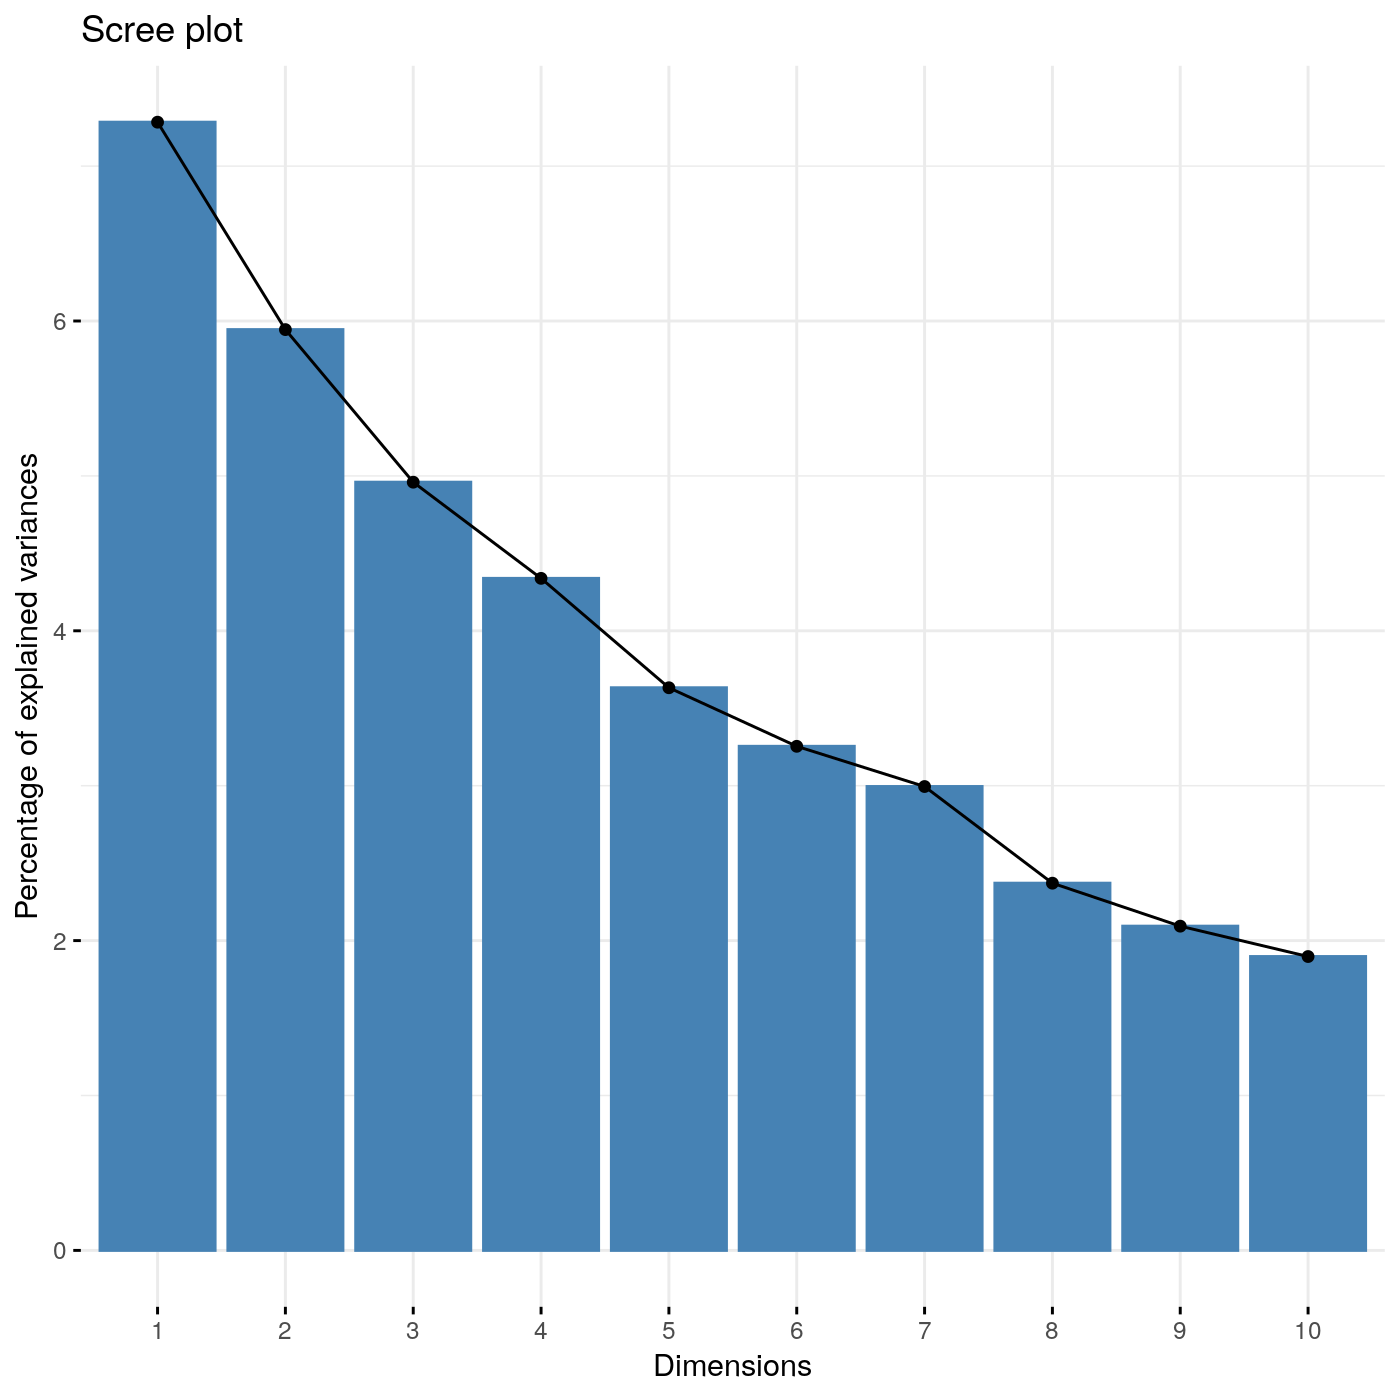

In [9]:
fviz_screeplot(r.mfa)

Since the first PCA only explains 7% of the variance, and together the first five dimensions only explain ~25% of the variance, we do not expect a PCA plot to separate the subtypes. But let's plot it and see.

Warning message in if (col.ind %in% c("cos2", "contrib", "coord")) partial = NULL:
“the condition has length > 1 and only the first element will be used”
Warning message in if (col.ind %in% c("cos2", "contrib", "coord")) partial = NULL:
“the condition has length > 1 and only the first element will be used”


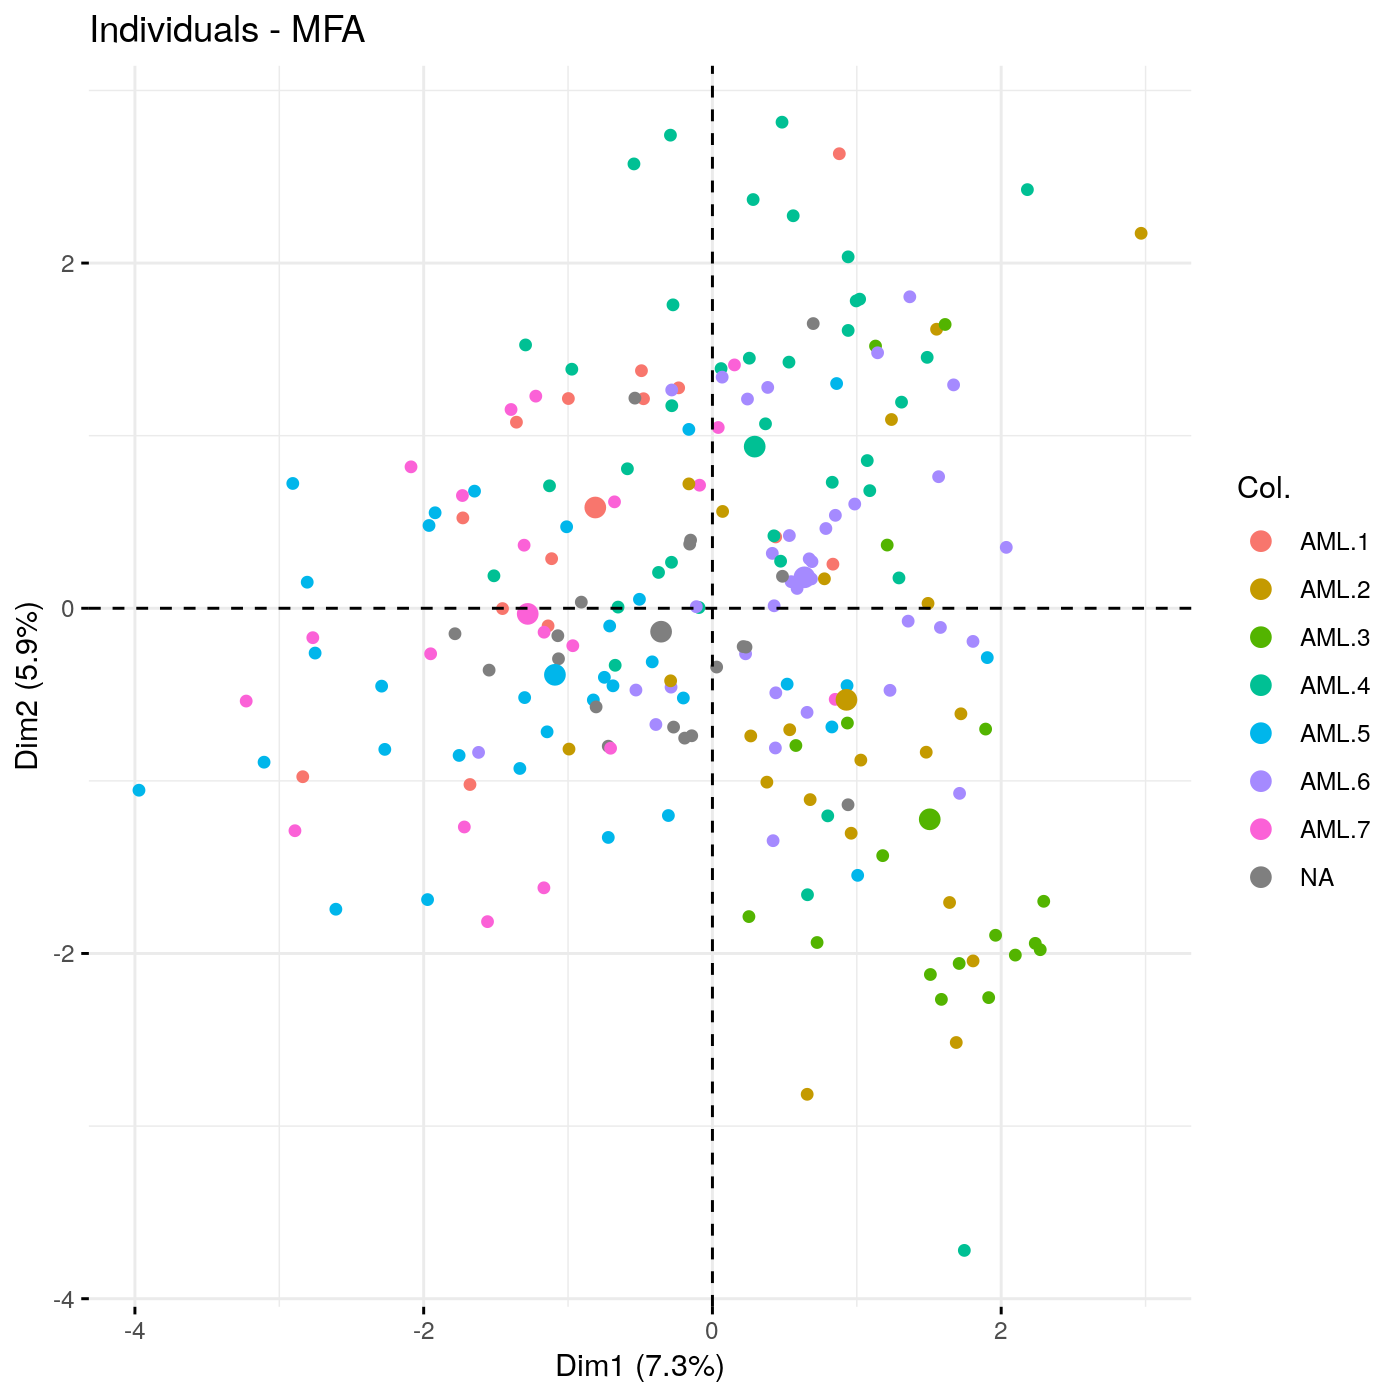

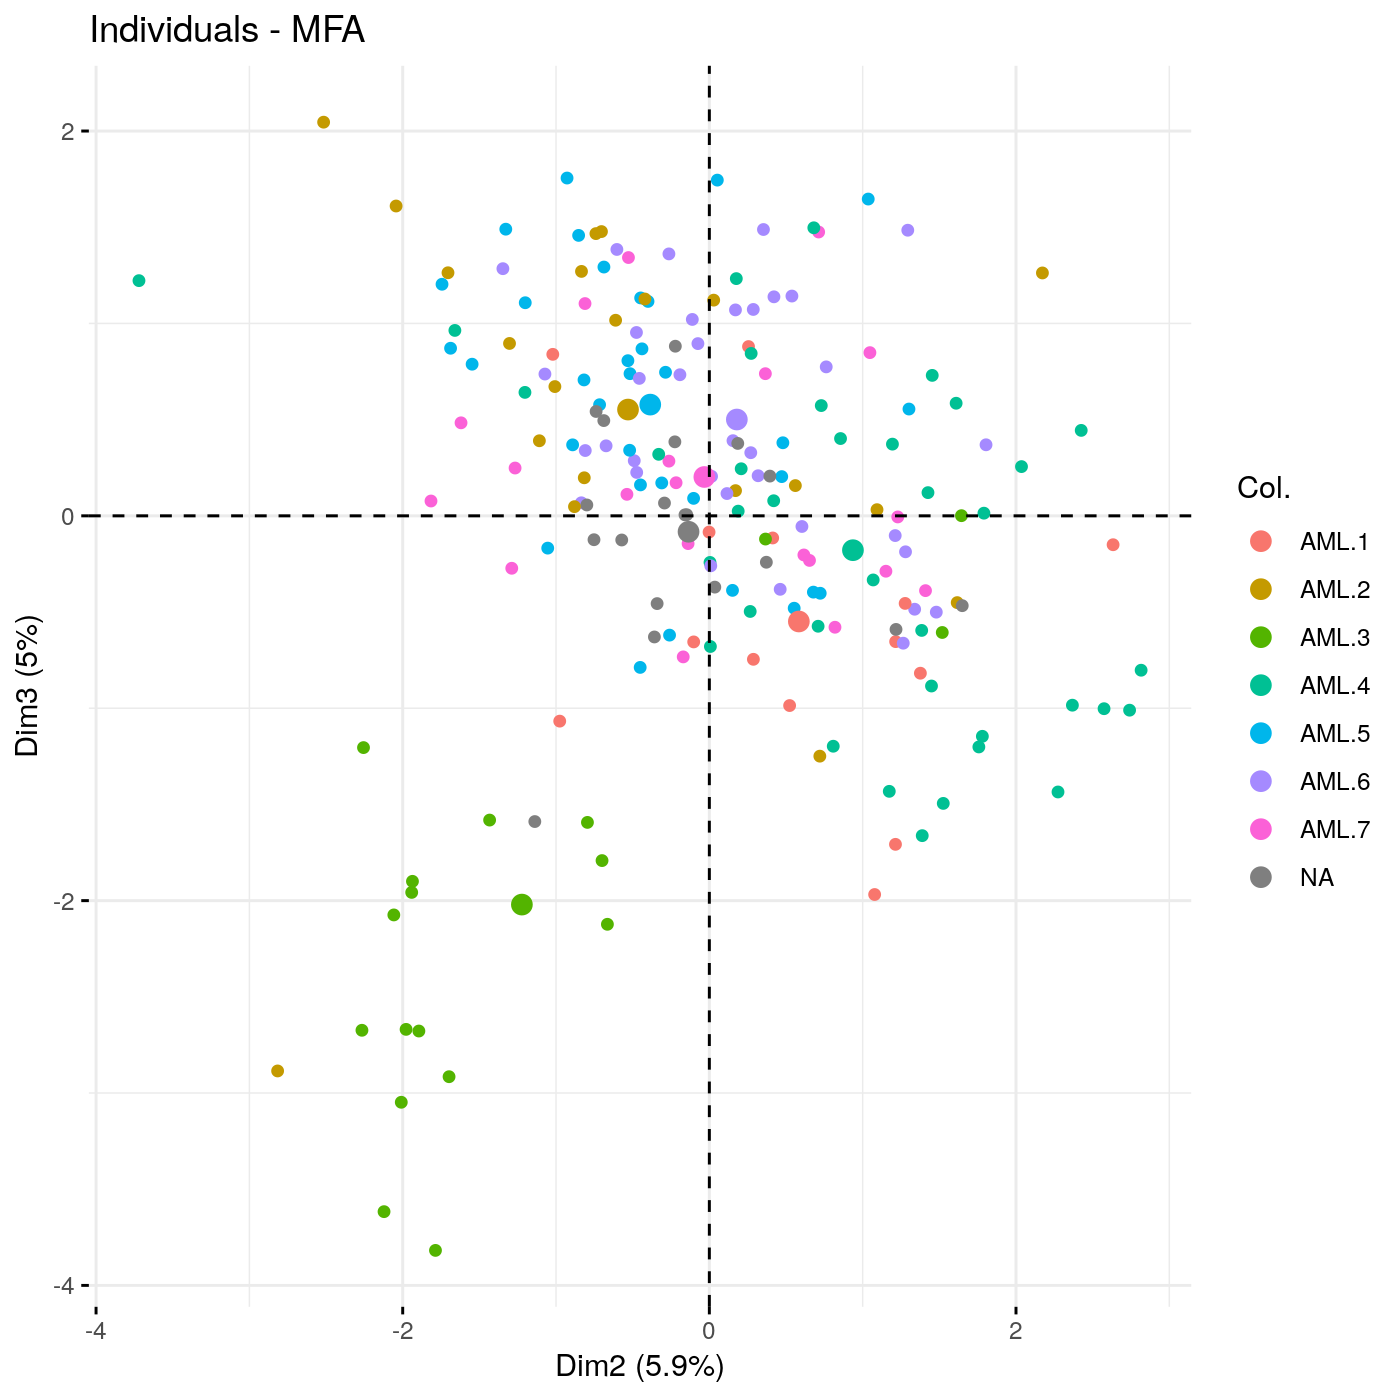

In [10]:
fviz_mfa_ind(r.mfa, col.ind = subtypes_data$Subtype_Selected, geom="point", axes=c(1,2))
fviz_mfa_ind(r.mfa, col.ind = subtypes_data$Subtype_Selected, geom="point", axes=c(2,3))

So we do see separation of AML.3 from the other subtypes. It certainly appears that AML.3 is a distinct subtype, even from this basic analysis. Now PCA plots focus on the global structure of the data, but other methods allow you to balance the global structure in the data with the local structure of the data. Let's see if using T-SNE one such method allows us to see the same structure, albeit from a little different perspective.

In [11]:
# first, extract the H and W matrices from the MFA run result
mfa.h <- r.mfa$global.pca$ind$coord
mfa.w <- r.mfa$quanti.var$coord

# create a dataframe with the H matrix and the subtype labels
mfa_df <- as.data.frame(mfa.h)
mfa_df$subtype_miRNA <- factor(subtypes_data$Subtype_miRNA)
mfa_df$subtype_mRNA <- factor(subtypes_data$Subtype_Selected)

mfa_df %>% head()

Dim.1      Dim.2      Dim.3       Dim.4       Dim.5      
TCGA.AB.2803.03  0.2527631 -1.7862573 -3.81796632 -0.99349053  0.89195643
TCGA.AB.2805.03 -0.1633910  1.0362848  1.64650406 -0.17931261 -0.73357725
TCGA.AB.2806.03  1.0196146  1.7908275  0.01381809 -2.45432524 -1.08710842
TCGA.AB.2807.03  2.0351645  0.3528843  1.48821003 -0.01699301  0.09485044
TCGA.AB.2808.03  0.8601374  1.3019416  0.55507317 -1.63230868 -1.62069228
TCGA.AB.2810.03 -0.4773419  1.2139515 -1.70745306  2.63844214  0.68582922
                subtype_miRNA subtype_mRNA
TCGA.AB.2803.03 5             AML.3       
TCGA.AB.2805.03 1             AML.5       
TCGA.AB.2806.03 4             AML.4       
TCGA.AB.2807.03 4             AML.6       
TCGA.AB.2808.03 4             AML.5       
TCGA.AB.2810.03 3             AML.1

In [12]:
# We run tSNE to visually inspect the MFA factors separate the samples
mfa.h.tsne <- tsne(mfa.h)
mfa.h.tsne.tbl <- as_tibble(mfa.h.tsne) %>%
    rename(tSNE_1=V1, tSNE_2=V2) %>%
    mutate(sample_codes = rownames(mfa.h)) 

sigma summary: Min. : 0.415658909962982 |1st Qu. : 0.538223861612916 |Median : 0.587855264486558 |Mean : 0.59566562576262 |3rd Qu. : 0.637941969661125 |Max. : 0.885911269418172 |

Epoch: Iteration #100 error is: 14.7136933727122

Epoch: Iteration #200 error is: 0.478795581559119

Epoch: Iteration #300 error is: 0.451712604898383

Epoch: Iteration #400 error is: 0.445951620253495

Epoch: Iteration #500 error is: 0.445452512064947

Epoch: Iteration #600 error is: 0.426093716904076

Epoch: Iteration #700 error is: 0.395534477592043

Epoch: Iteration #800 error is: 0.395525518369005

Epoch: Iteration #900 error is: 0.395524631096228

Epoch: Iteration #1000 error is: 0.39552453901088

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


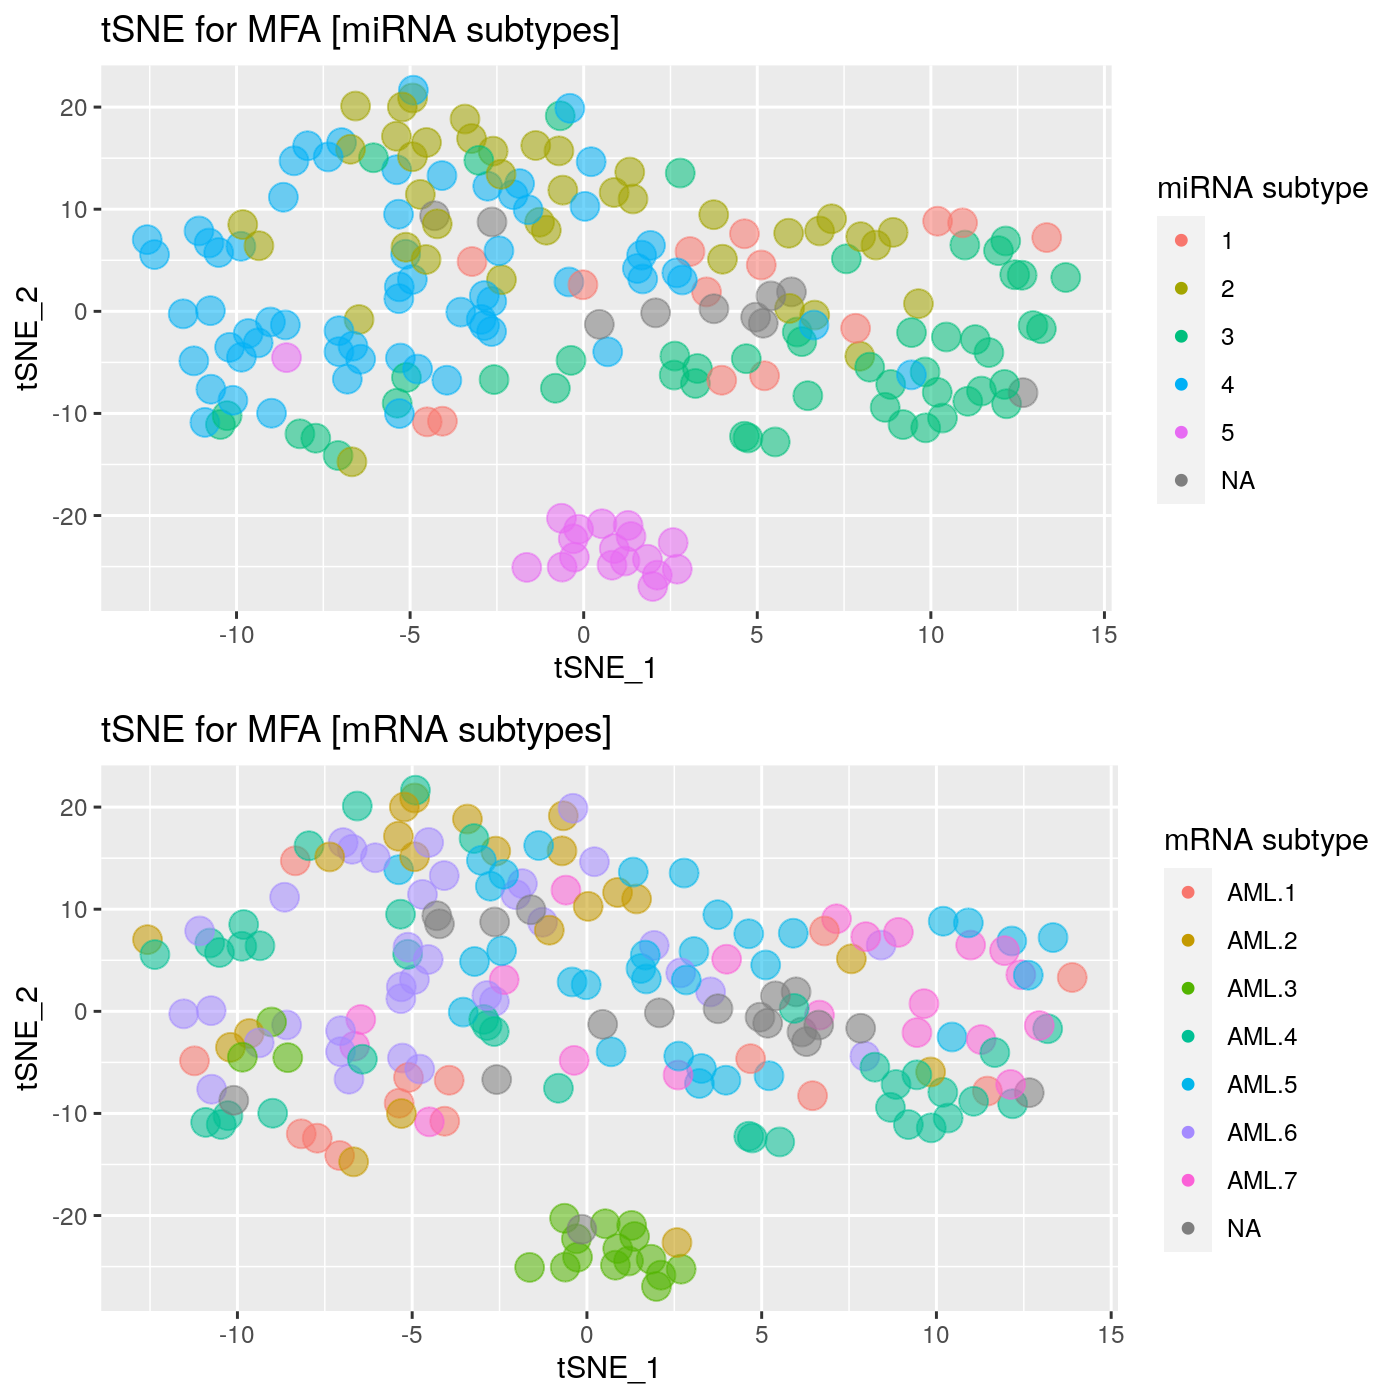

In [13]:
p1 <- mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_miRNA), size=1, alpha=0.5)) + 
    labs(title="tSNE for MFA [miRNA subtypes]", color="miRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p2 <- mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_Selected), size=1, alpha=0.5)) + 
    labs(title="tSNE for MFA [mRNA subtypes]", color="mRNA subtype") + guides(alpha=FALSE, size=FALSE) 

ggarrange(p1, p2, ncol = 1) 

Again, we see that AML.3 is well separated, and the separation between AML.3 and other subtypes is clearer in this plot

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


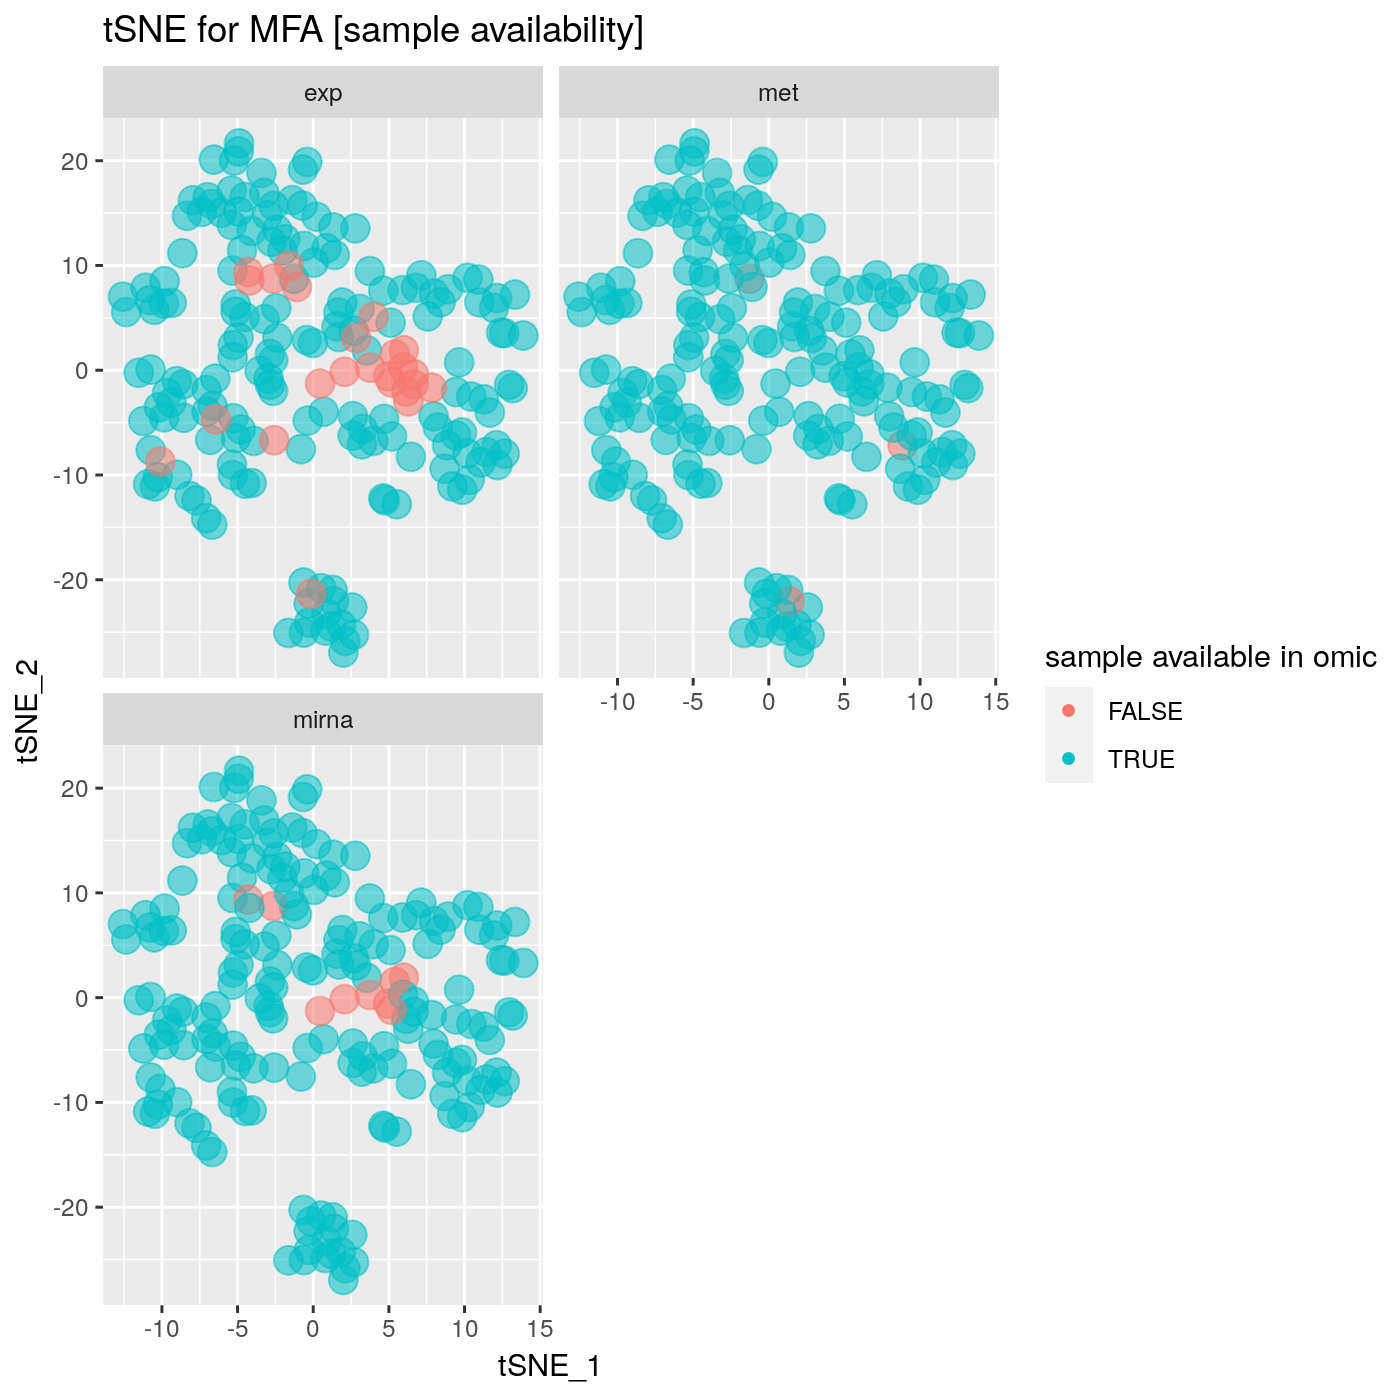

In [14]:
# let's check if our introduction of missing values (by matrix concatenation) do not drives sample separation
mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    select(tSNE_1, tSNE_2, exp, met, mirna) %>%
    gather(omic, sample.available, -tSNE_1, -tSNE_2) %>%
    ggplot() + 
      geom_point(aes(x=tSNE_1, y=tSNE_2, color=sample.available, size=1, alpha=0.1)) + 
      facet_wrap(omic~., ncol=2) +
      labs(title="tSNE for MFA [sample availability]", color="sample available in omic") + 
      guides(alpha=FALSE, size=FALSE)


Another way to examine the MFA factors, which does not require us to do additional data transformation is a heatmap.

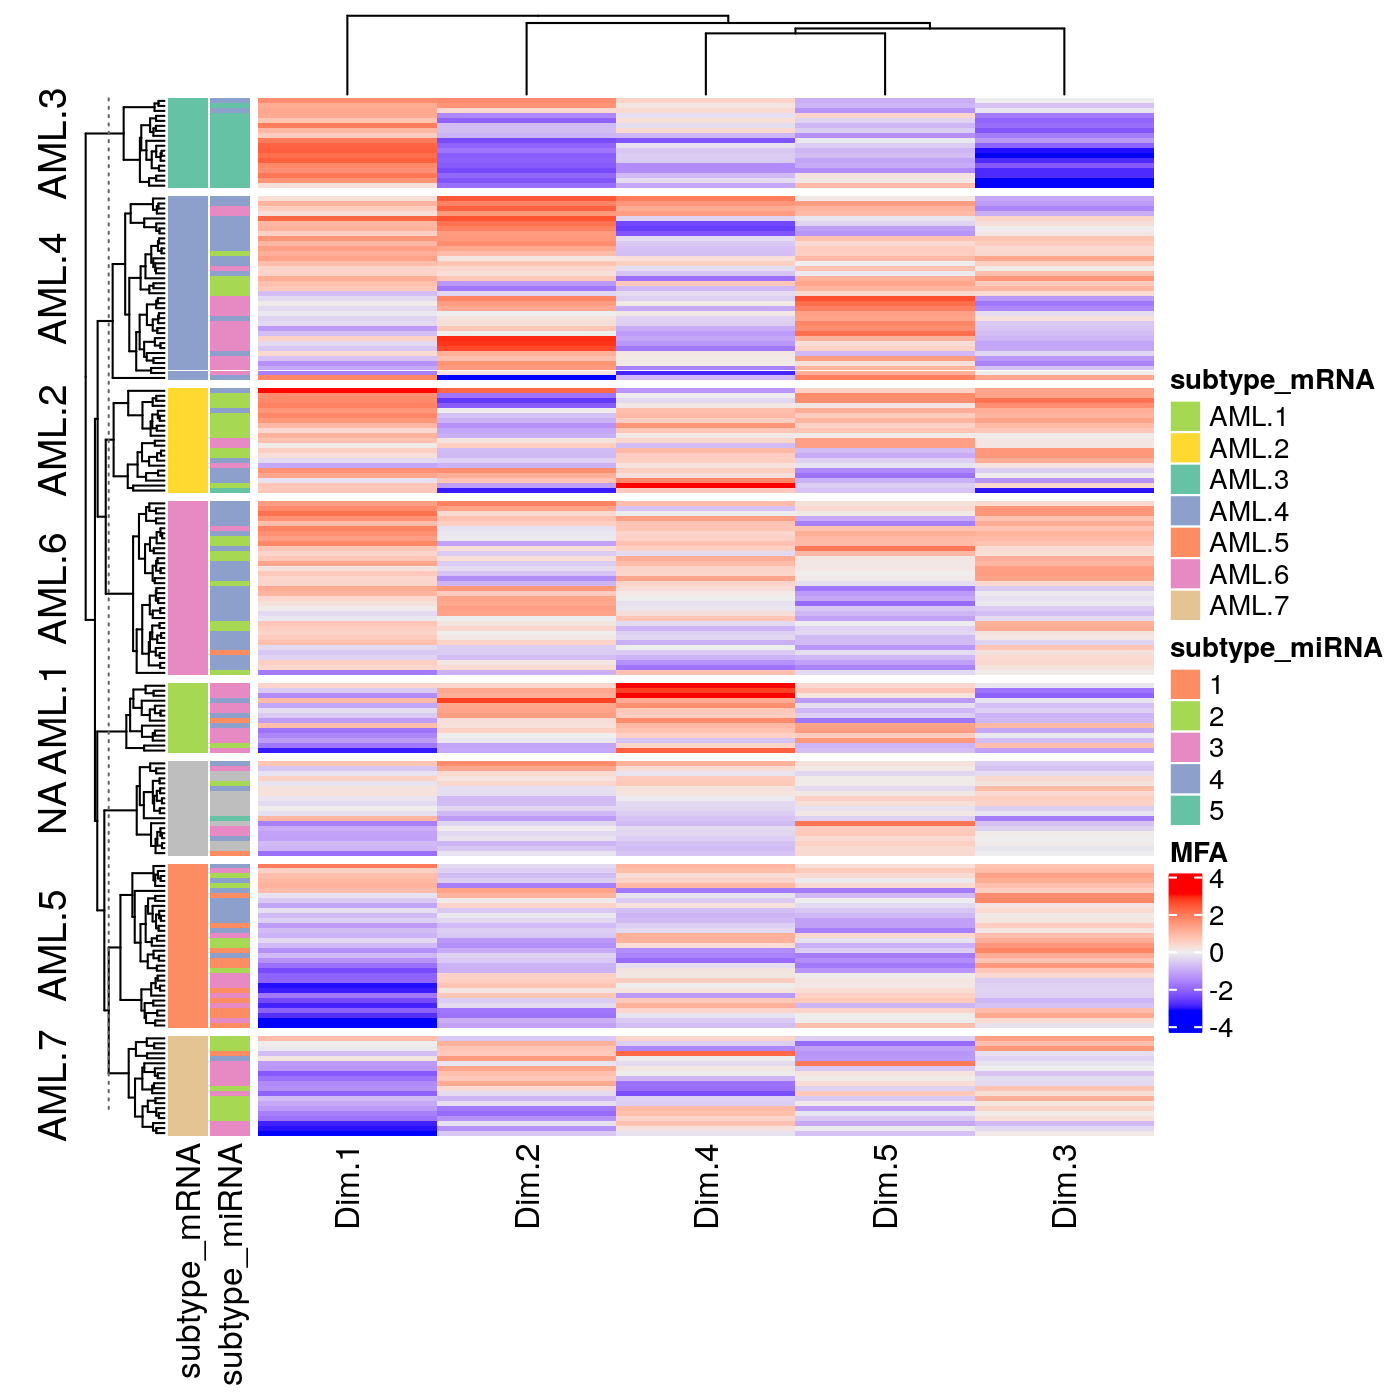

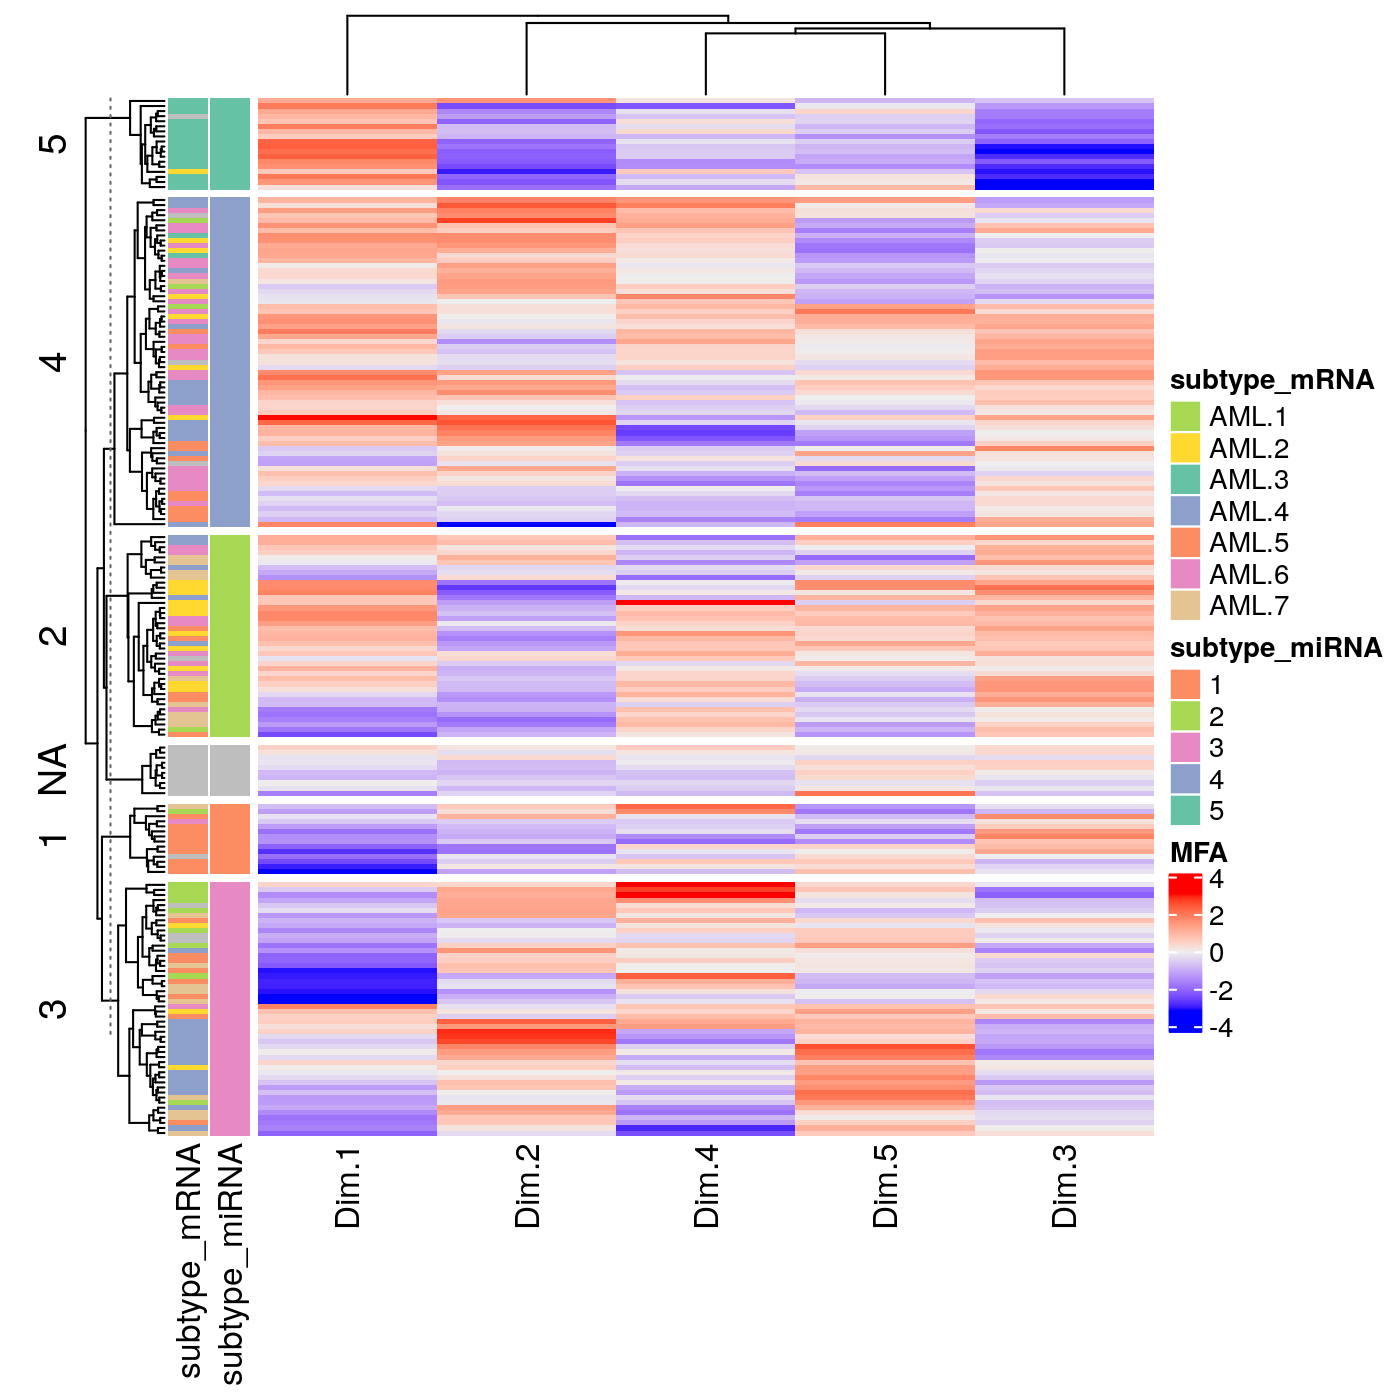

In [15]:
Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      subtype_miRNA=mfa_df$subtype_miRNA,
                                          col = list(subtype_mRNA=exp_subtypes_col, 
                                                     subtype_miRNA=miRNA_subtypes_col)),
       row_split=mfa_df$subtype_mRNA)

Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      subtype_miRNA=mfa_df$subtype_miRNA,
                                          col = list(subtype_mRNA=exp_subtypes_col, 
                                                     subtype_miRNA=miRNA_subtypes_col)),
       row_split=mfa_df$subtype_miRNA)


- As we noted during our introductory data exploration, both TCGA classifications are videly different. 
- There is group of samples (miRNA 5/ AML.3) differentiating based on both gene and miRNA expression.

### Clustering using latent factors

A common analysis in biological investigations is clustering. This is often interesting in cancer studies as one hopes to find groups of tumors (clusters) which behave similarly, i.e. have similar risks and/or respond to the same drugs. PCA is a common step in clustering analyses, and so it is easy to see how the latent variable models above may all be a useful pre-processing step before clustering. 

Here, we use K-means clustering method to invsestigate clusters in our MFA results. This method divides or partitions the data points, our working example patients, into a pre-determined, *K* number of clusters. How do we know which *K* to choose? This is a very difficult question. When visualized it is not always easy to assess the results (especially if we cannot plot them directly). Should we consider a large cluster as one cluster or should we consider the sub-clusters as individual clusters? There are some metrics to help but there is no definite answer. For biological datasets there is no "ground truth" that we can compare against. What remains is the careful assessment of range of possible *K* values using diffrent clusteing metrics. For example we may check the cluster stability (so the resistence of clusters to data perturbation) or assess the similarity between samples assigned to the same cluster (cluster silhouettes).

Moreover it is important to leverage the shortcomings of used model and biological data. Here, the clusters found (when using *K*=7) do not correspond to most commonly used subtypes per the TCGA metadata. However we know that the subtype assignments were created using only the gene expression, so we could expect that it could be the case. We will re-visit this subtype-cluster comparison in the further section of this tutorial.

In [16]:
# use the kmeans function to cluster the H matrix for a range of k values
mfa.clusters <- sapply(2:10, function(x) kmeans(mfa.h, x)$cluster)
colnames(mfa.clusters) <- paste0("kmeans_k", 2:10)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


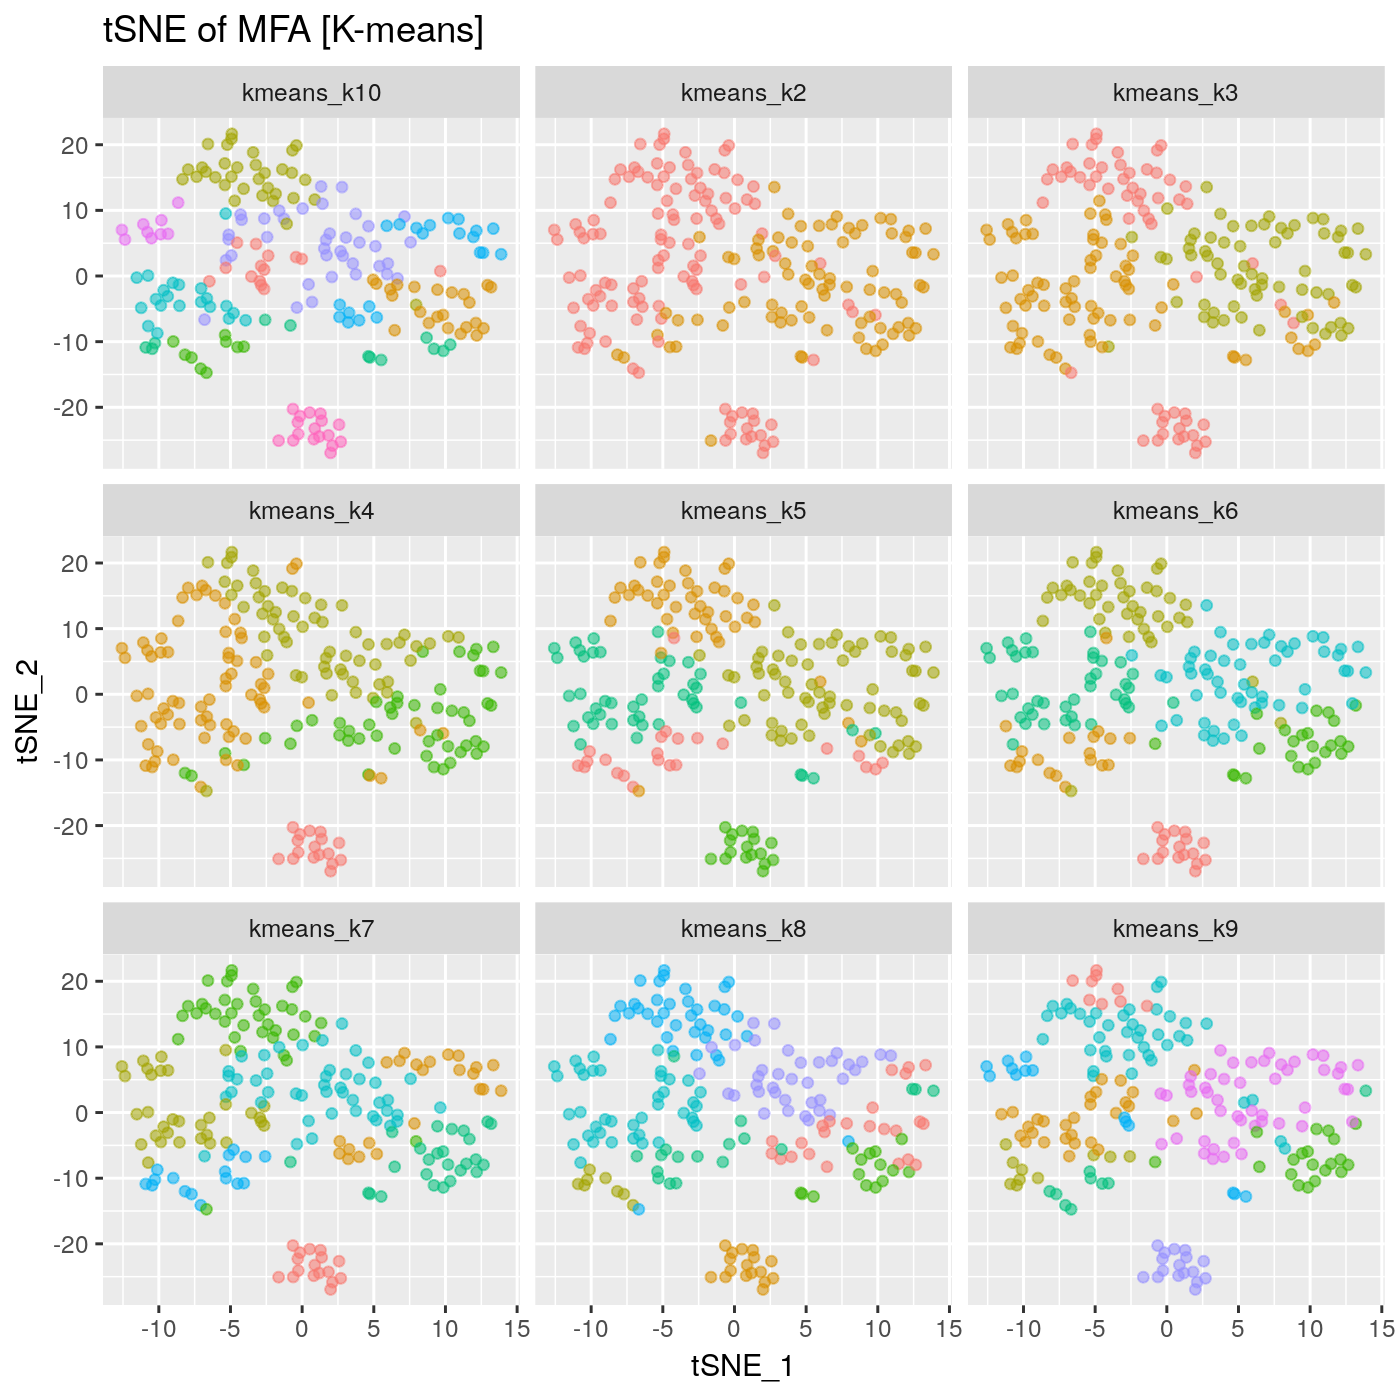

In [17]:
mfa.clusters %>%
    as_tibble() %>%
    mutate(sample_codes=rownames(mfa.clusters)) %>%
    left_join(mfa.h.tsne.tbl, by = "sample_codes") %>%
    gather(kmeans, label, -sample_codes, -tSNE_1, -tSNE_2) %>%
    mutate(label=as.factor(label)) %>%
    ggplot() +
      geom_point(aes(x=tSNE_1, y=tSNE_2, color=label, alpha=0.1)) + 
      facet_wrap(kmeans~., ncol=3) +
      labs(title="tSNE of MFA [K-means]", color="label") + 
      guides(alpha=FALSE, size=FALSE, color=FALSE)

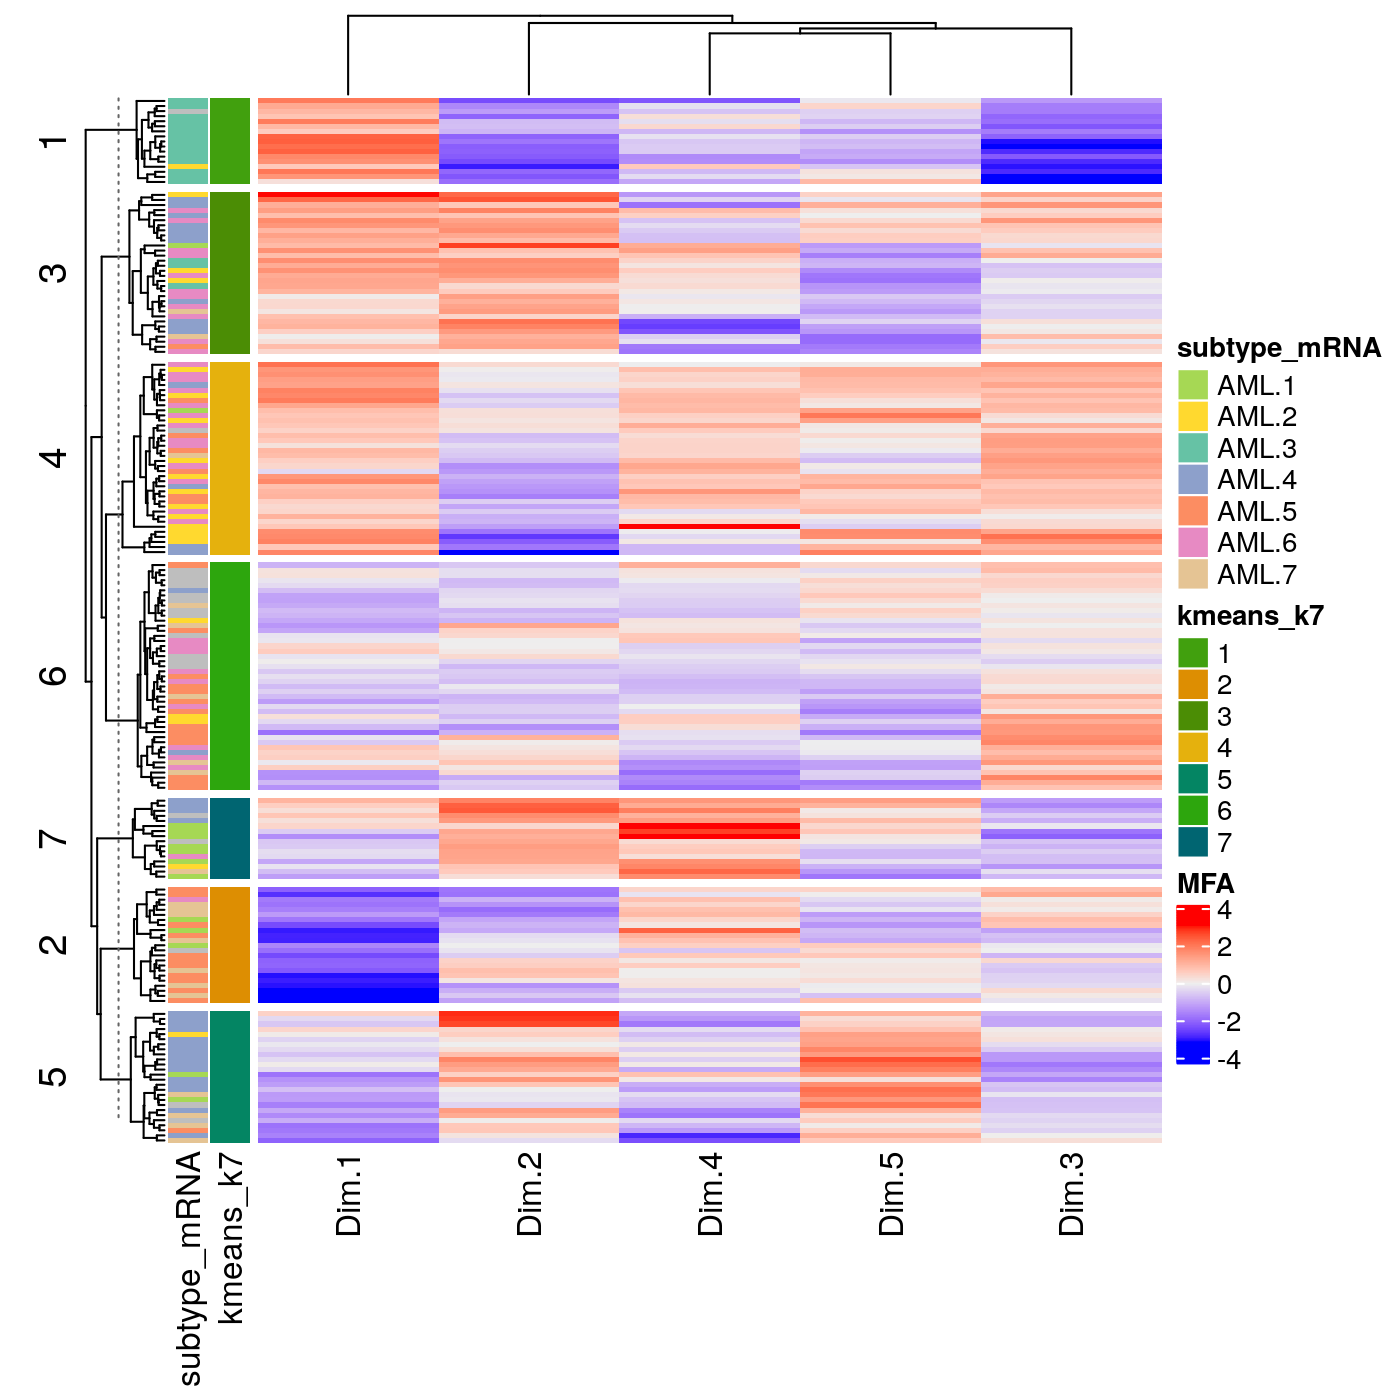

In [18]:
# comparing the Kmeans results for k=7 with TCGA subtypes
kmeans.res <- factor(mfa.clusters[, c('kmeans_k7')])
Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      kmeans_k7=kmeans.res,
                                          col = list(subtype_mRNA=exp_subtypes_col)),
       row_split=kmeans.res)

**(Optional) exercise**:

1. The default call to MFA assume five factors (see above heatmap), however, looking at the scree plot of the resulting PCA we observed the first five PCs only explain 25% of the variance. This is an indicator that our integrated dataset might have a lot of clusters. Further, the subsequent clustering after MFA using only these five latent factors might not result in well separated clusters. Investigate how the results will change if we include more latent factors? What number of latent factors would you select? 

Hint: The criteria used for the PCA analysis to select the number of components to keep would apply here. Start with investigating the "r.mfa$eig" matrix.


## (2) iCluster & iCluster+

iCluster takes a Bayesian approach to the latent variable model. In Bayesian statistics, we infer distributions over model parameters, rather than finding a single maximum-likelihood parameter estimate. In iCluster, we model the data as: 

**X(i) = W(i)Z + ϵ_i**,

where:
- X(i) is a data matrix from a single omics platform,
- W(i) are model parameters,
- Z is a latent variable matrix shared among different omics platforms,
- ϵ_i is a normally distributed noise matrix, a random variable ϵ_i ∼ N(0,Ψ) with Ψ=diag(ψ_1,…ψ_M) a diagonal covariance matrix.

<img src="https://compgenomr.github.io/book/images/icluster.png">

With this construction, the omics measurements X(i) are expected to be similat for samples with the same latent variable representation up to Gaussian noise. iCluster maximizes the likelihood of the observed data with an additional Lasso-regularization to impose sparsity on W(i) matrices. Optimization is performed using an EM-like algorithm, briefly: 

- the W(i) and Ψ matrices are initialized, 
- the expected value of Z is calculated given current W(i), Ψ and X values ("E-step"), 
- followed by maximum likelihood estimation for W(i) and Ψ values given current estimate of Z and the data X ("M-step"). 
- the "E" and "M" steps are repeated until the covergence of W, Ψ.

Again the "K-means" is run on the lower dimension representation of the final Z to get the final clustering assignments.

iCluster+ is an extension of the iCluster framework, which allows for **omics types to arise from distributions other than a Gaussian**. While normal distributions are a good assumption for log-transformed, centered gene expression data, it is a poor model for binary mutations data, or copy number variation data. iCluster+ allows the different X(i) to have different distributions:
- for binary mutations, X is drawn from a multivariate binomial
- for normal, continuous data, X is drawn from a multivariate Gaussian 
- for copy number variations, X is drawn from a multinomial
- for count data, X is drawn from a Poisson.

iCluster+ fits a regularized latent variable model based clustering that generates an integrated cluster assignment based on joint Bayesian inference across data types.

iCluster+ remains one of the most popular mulit-omic integration method, however it is important to note that it supports only **the integration of data matrices with equal number of samples and no missing values**. Here, we subset our dataset and use only the samples common for all our data types. Moreover the execution time of iCluster+ is deffinetly worth consideration. For the datasets with high number of features, **additional feature selection step may be required**.

In [19]:
common_samples <- subtypes_data %>% filter(exp & met & mirna) %>% pull(sample_codes)
exp.common <- data_exp[, common_samples]
met.common <- data_met[, common_samples]
mirna.common <- data_mirna[, common_samples]

In [20]:
# run the iClusterPlus function on common samples data set (this will take a couple of minutes)
r.icluster <- iClusterPlus(
  t(exp.common), # Providing each omics type
  t(met.common),
  t(mirna.common),
  type=rep("gaussian", 3), # Providing the distributions
  K=6, # provide the number of factors to learn (number of clusters is k+1)
  alpha=c(1,1,1), # as well as other model parameters
  lambda=c(.03,.03,.03))

How do we decide on model parameters? Usually, we would like to use the parallel computing (and "tune.iClusterPlus" function) to search throught the parameter space to look for the best model or the minimum Bayesian information criterion (BIC) value. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC attempts to resolve this problem by introducing a penalty term for the number of parameters in the model. The number of point to sample (n.lambda) depends on the number of data.types - see the [iCluster+ user manual](https://www.mskcc.org/sites/default/files/node/18547/documents/iclusterplususerguide_0.pdf) for more details.
This step is very time consuming so we omit it in this tutorial. 

In [64]:
# extract the H and W matrices from the run result
# here, we refer to H as z, to keep with iCluster terminology
icluster.z <- r.icluster$meanZ
rownames(icluster.z) <- colnames(exp.common) # fix the row names
icluster.ws <- r.icluster$beta

In MFA the Dim.1 is the factor which has the more variance, if we don't know if this is the case it is a good idea to look closer at our factor matrix. Here is a quick way to plot the various pairs of factors:

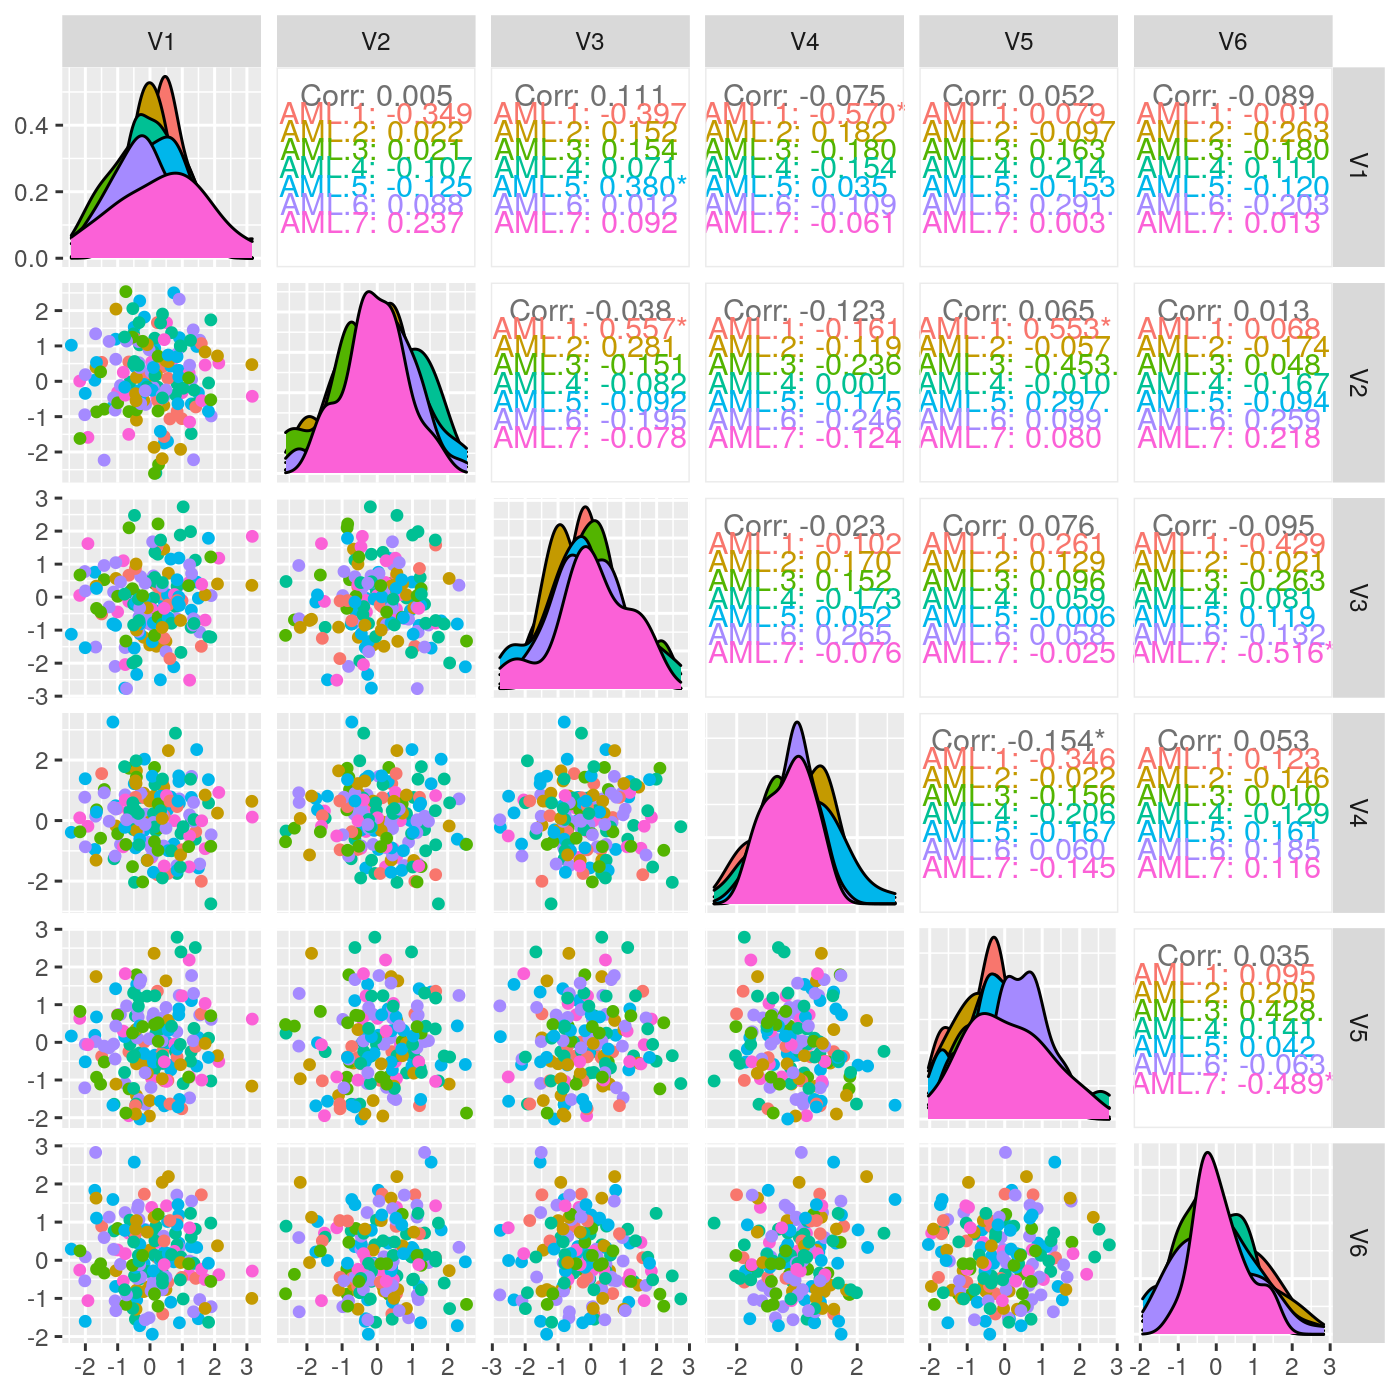

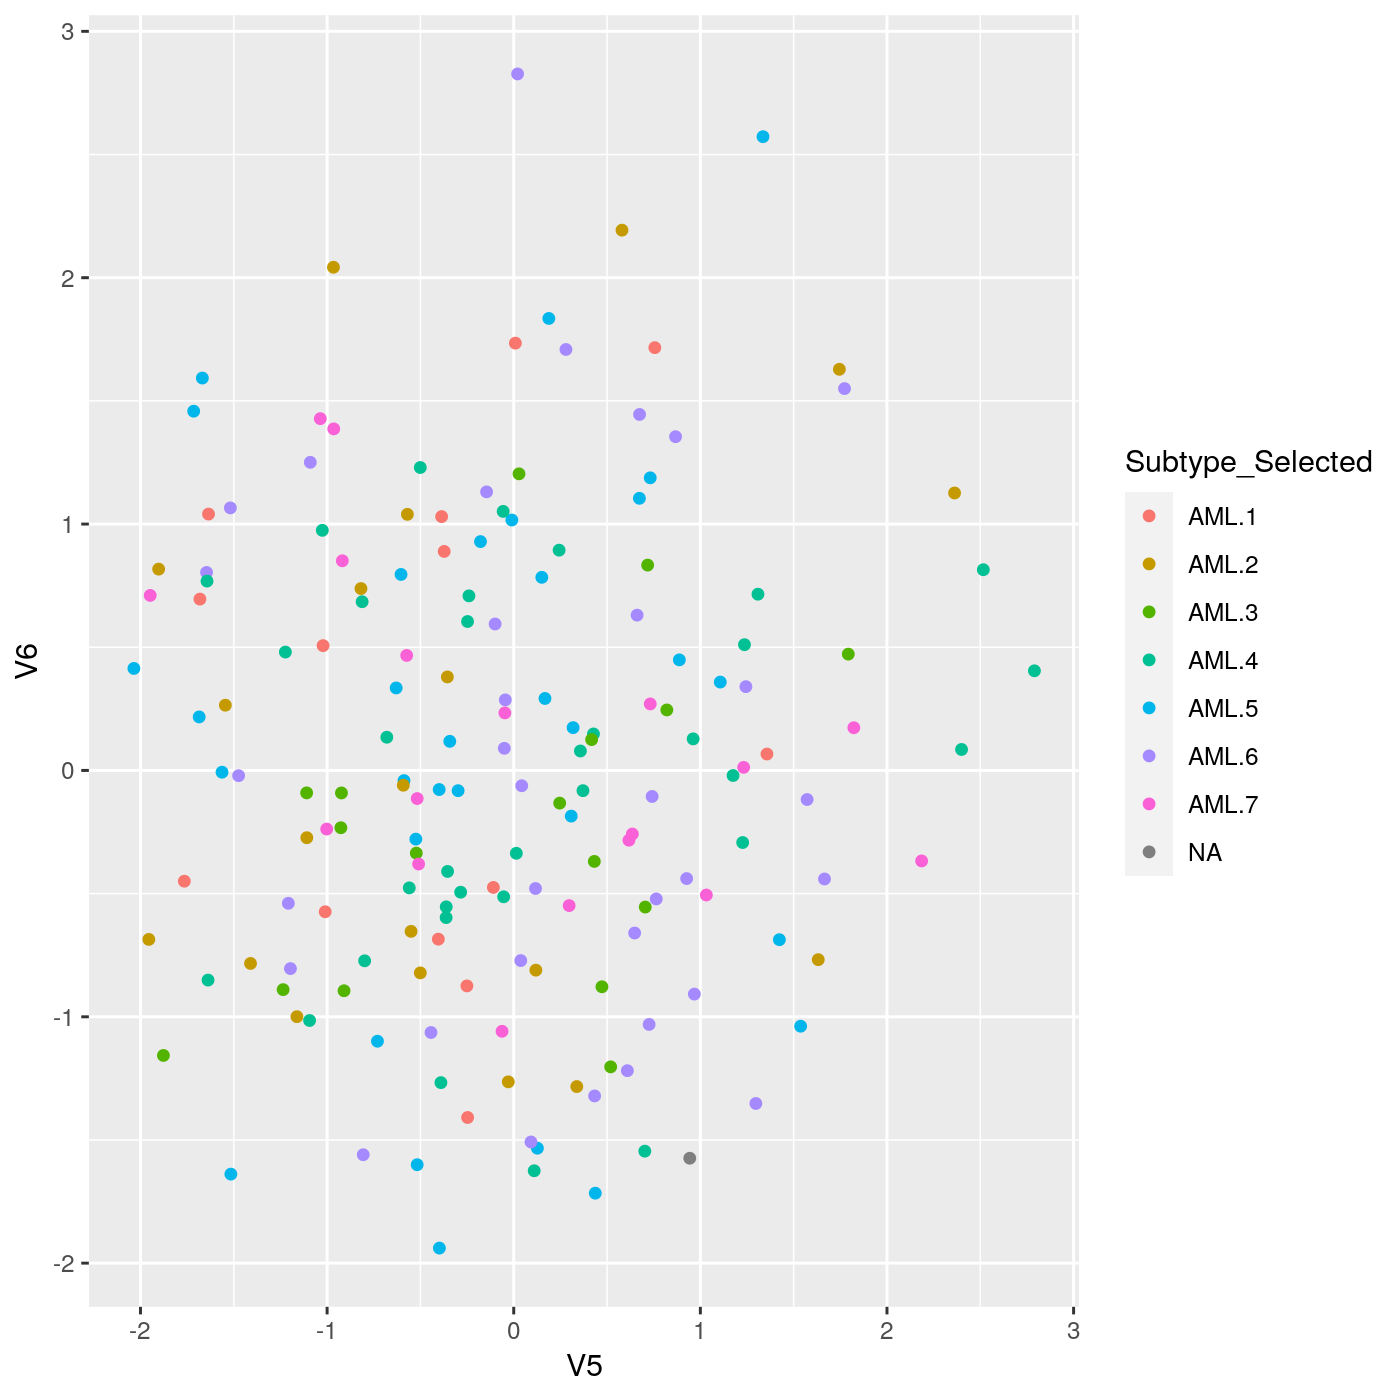

In [22]:
# insight into multiple pairs of factors
as_tibble(icluster.z, rownames="sample_codes") %>% 
    left_join(subtypes_data, by = "sample_codes") %>%
    select(sample_codes,V1,V2,V3,V4,V5,V6,Subtype_Selected) %>%
    na.omit() %>%
    ggpairs(columns=2:7, ggplot2::aes(col=Subtype_Selected))
# plot specific pair of factors
as_tibble(icluster.z, rownames="sample_codes") %>% 
    left_join(subtypes_data, by = "sample_codes") %>%
    select(sample_codes,V1,V2,V3,V4,V5,V6,Subtype_Selected) %>%
    ggplot(aes(V5,V6,col=Subtype_Selected)) + geom_point()

In [23]:
# We run tSNE for visualization purposes and inspect sample separation by existing subtypes
icp.tsne <- tsne(icluster.z)
icp.tsne.tbl <- as_tibble(icp.tsne) %>%
    rename(tSNE_1=V1, tSNE_2=V2) %>%
    mutate(sample_codes = colnames(exp.common))

sigma summary: Min. : 0.493345099668624 |1st Qu. : 0.567093611947498 |Median : 0.594772296771102 |Mean : 0.598553066410966 |3rd Qu. : 0.630496931295731 |Max. : 0.744137313451994 |

Epoch: Iteration #100 error is: 14.9139409450551

Epoch: Iteration #200 error is: 0.767743216793889

Epoch: Iteration #300 error is: 0.715879007911224

Epoch: Iteration #400 error is: 0.710969077678062

Epoch: Iteration #500 error is: 0.702440547653133

Epoch: Iteration #600 error is: 0.702438306238872

Epoch: Iteration #700 error is: 0.702438295234512

Epoch: Iteration #800 error is: 0.702438294833226

Epoch: Iteration #900 error is: 0.702438294818333

Epoch: Iteration #1000 error is: 0.702438294817699



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


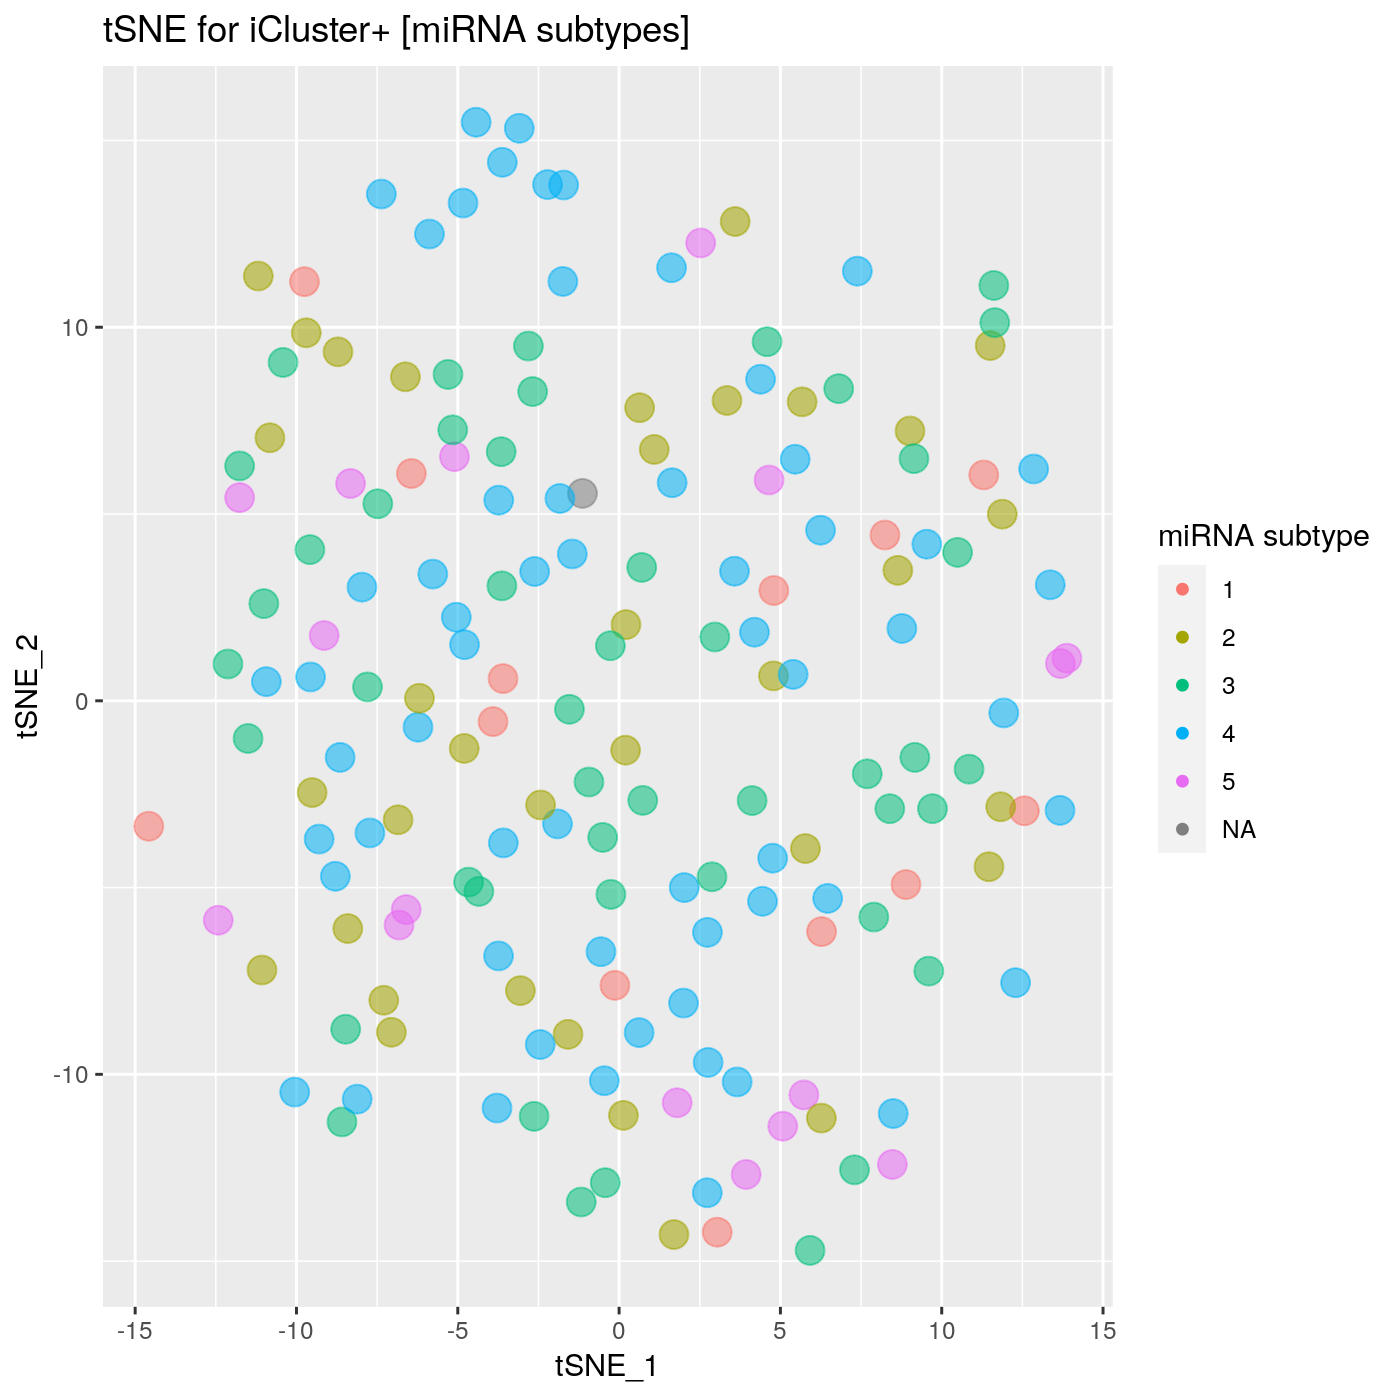

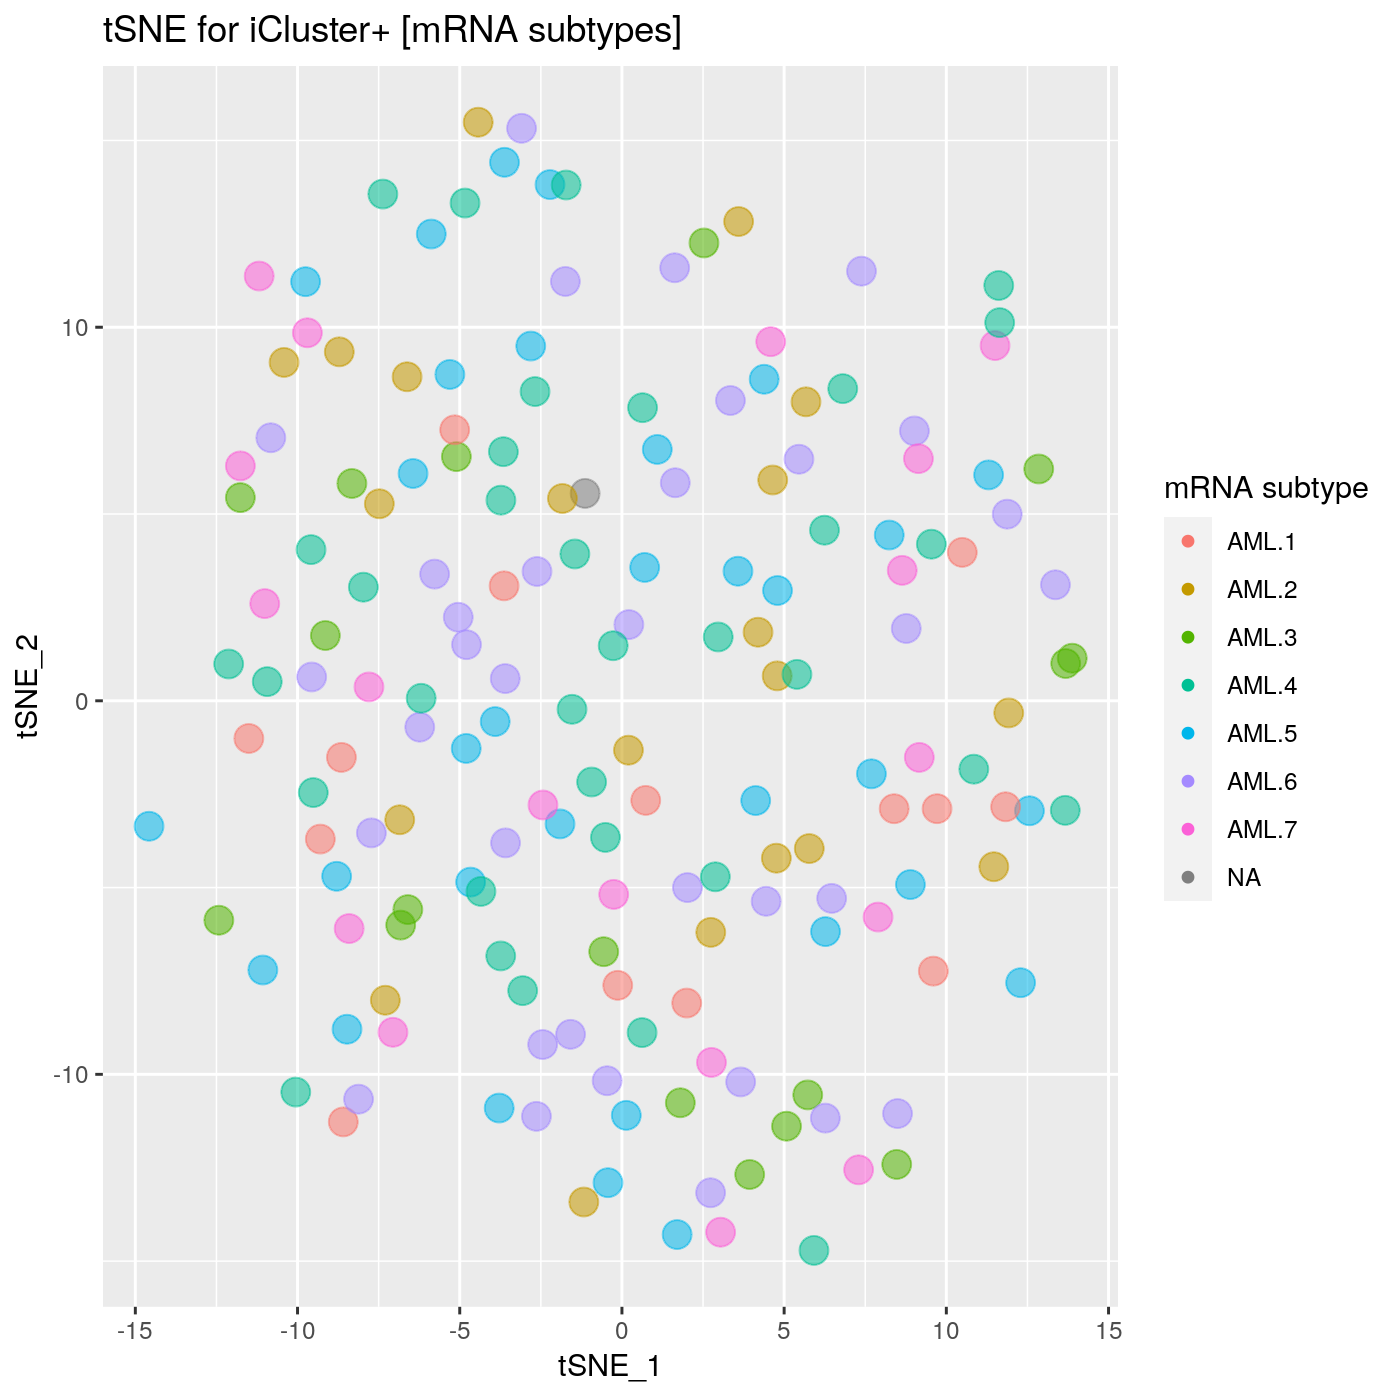

In [24]:
p1 <- icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_miRNA), size=1, alpha=0.5)) + 
    labs(title="tSNE for iCluster+ [miRNA subtypes]", color="miRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p2 <- icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
     ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_Selected), size=1, alpha=0.5)) + 
     labs(title="tSNE for iCluster+ [mRNA subtypes]", color="mRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p1
p2

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


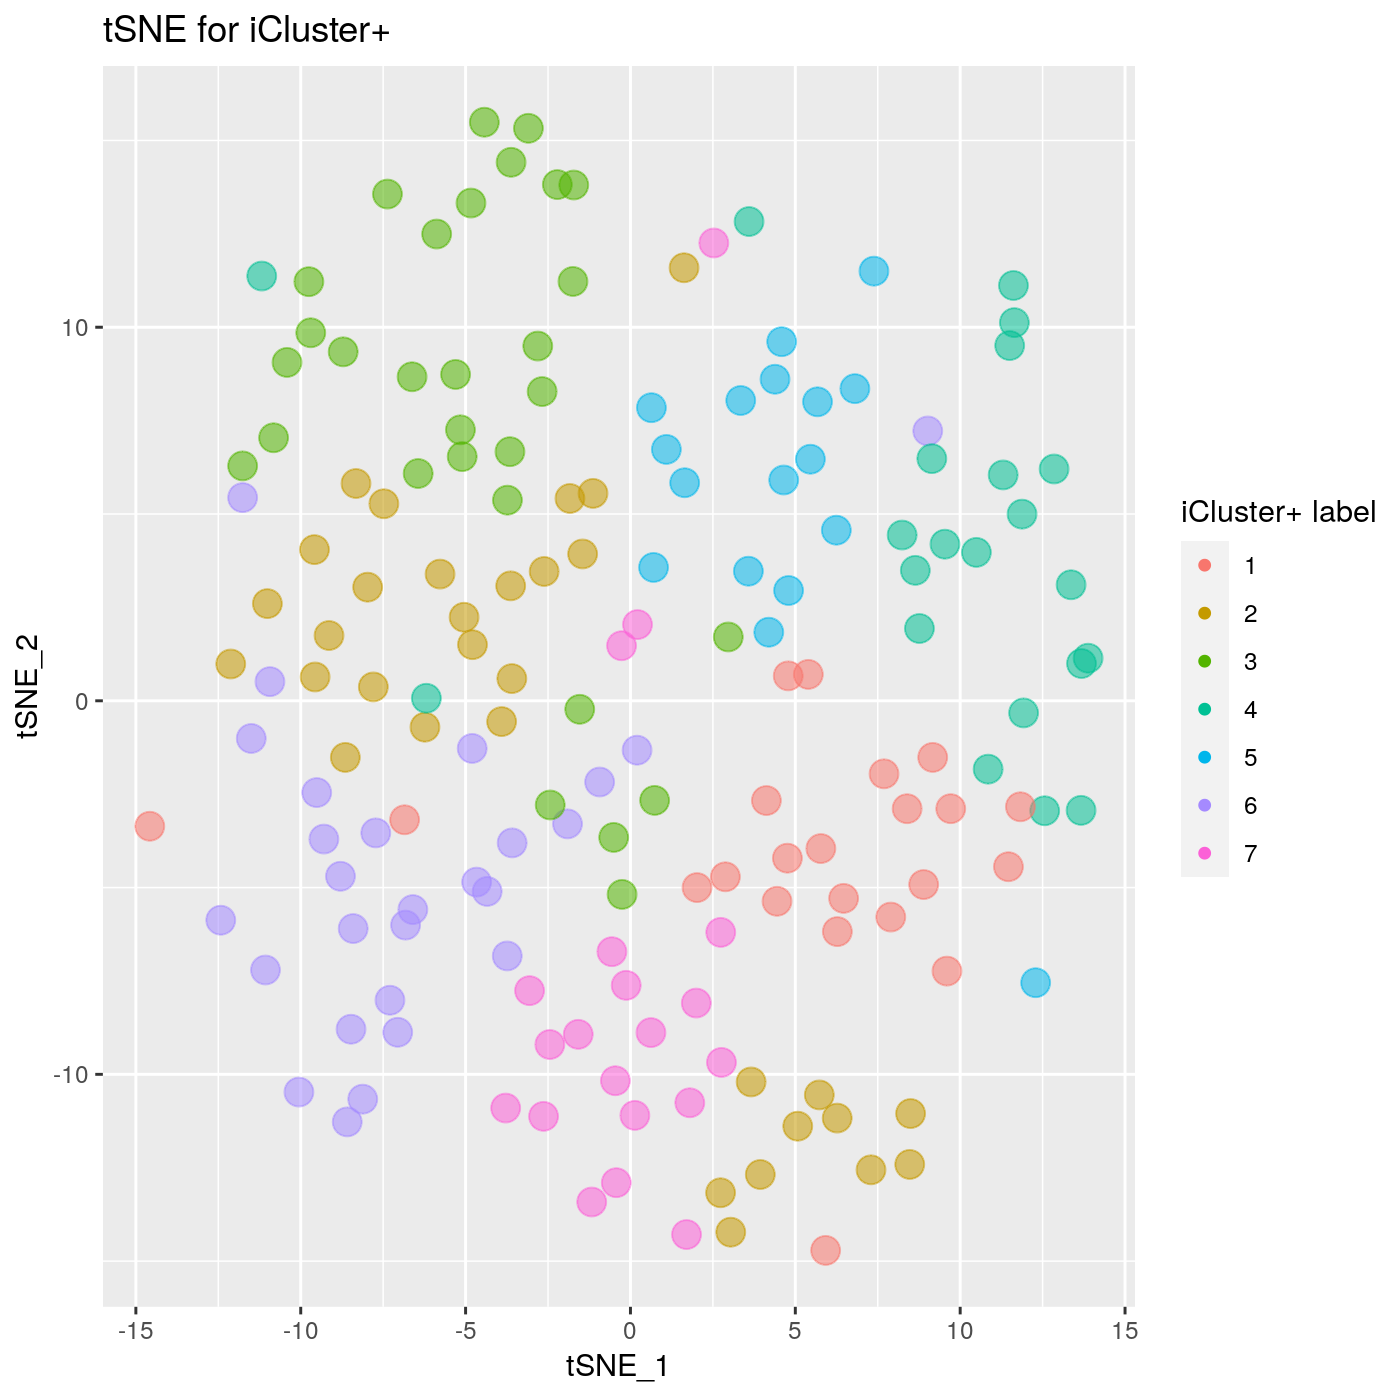

In [25]:
icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    mutate(icp_label=r.icluster$clusters) %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(icp_label), size=1, alpha=0.5)) + 
     labs(title="tSNE for iCluster+", color="iCluster+ label") + guides(alpha=FALSE, size=FALSE) 


## (3) PINS & PINS+

PINS is an example of late integration mulit-omic framework. This method works by the integration of **co-clustering patterns in separate omics**. The patterns are based on the assasement of cluster robustness to the perturbation of original data.

PINS clusters each data type separately and creates a **connectivity matrix** *S_i (n x n)*, where *n* is the number of samples. The *S_i(xy) = 1* if two samples are clustered together and *0* otherwise. The original data is then perturbed multiple times by the addition of Gaussian noise. Resulted connectivity matrices are then used to create a similarity matrix, by assessing the average pair-wise connectivity between the samples.
In the ideal case the similarity matrix defines groups of patients that are strongly connected across all of that data types. However, as we observed previously in practise it may not be the case. In this case the average connectivity value is used to create the similarity matrix. Finally the similarity matrix is partitioned to find sample labels. To assess if data follows hierarchical structure the connectivity assassment is repeated separately for sample groups identified in first stage, so samples can be split into subgroups if it's possible.

PINS+ is an extension of PINS that greatly improve the efficacy of the method. PINS+ require each data type to have the same number of samples, and no missing values in feature matrices.

In [26]:
pins.ret = SubtypingOmicsData(dataList=list(t(exp.common), t(met.common), t(mirna.common)), 
                                        kMax = 9,
                                        ncore = 2) #number of cores for parallel computing

Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 10.3467144966125 secs.


Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 7.05125331878662 secs.


Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 12.1754939556122 secs.


STAGE : 1	 Agreement : 0.214549251653324

Check if can proceed to stage II

Done in 29.9696862697601 secs.




In [27]:
clustering2 = pins.ret$cluster2
clustering1 = pins.ret$cluster1

Since PINS+ provides only sample labels and statistics/metrics calculated for specific data types (like perturbed and unperturb connectivity matrices), as opose to integrative matrices for multi-omic dataset, we are going to ivestigate how the clustering label separate samples in specific datasets.

In [28]:
exp.pca <- prcomp(t(exp.common))
mirna.pca <- prcomp(t(mirna.common))
met.pca <- prcomp(t(met.common))

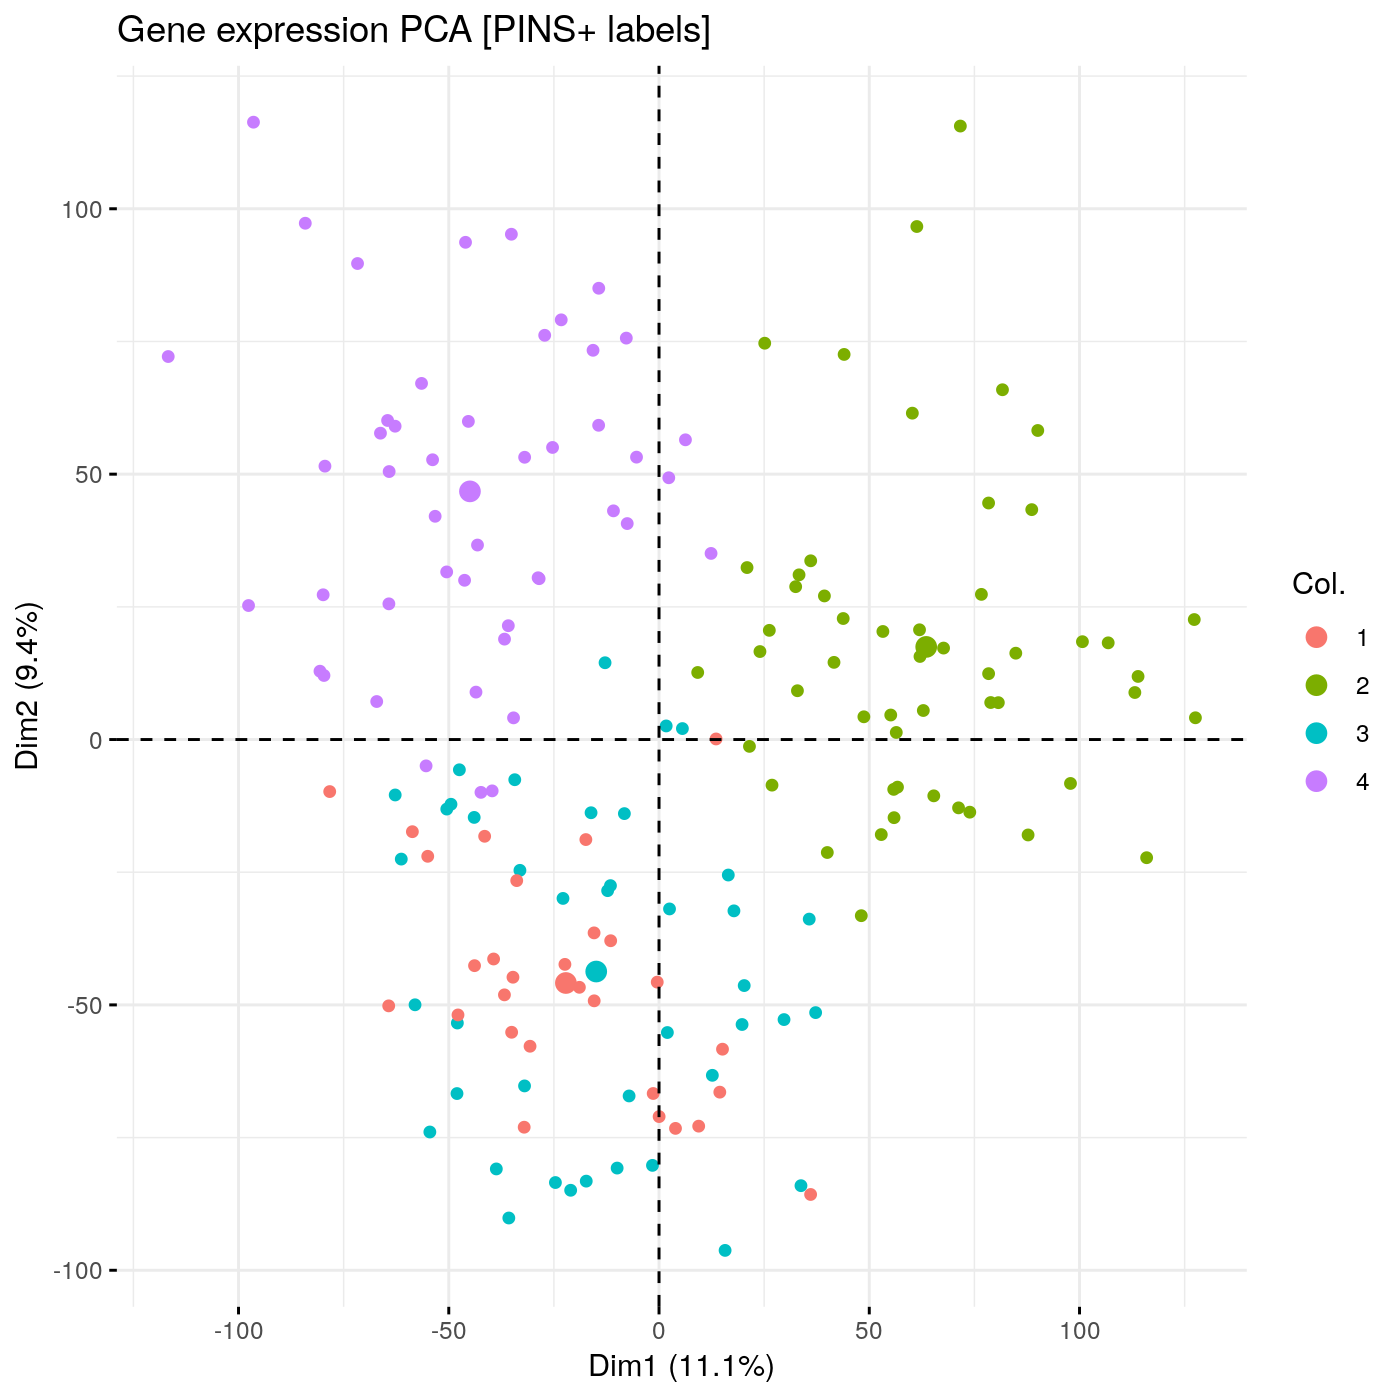

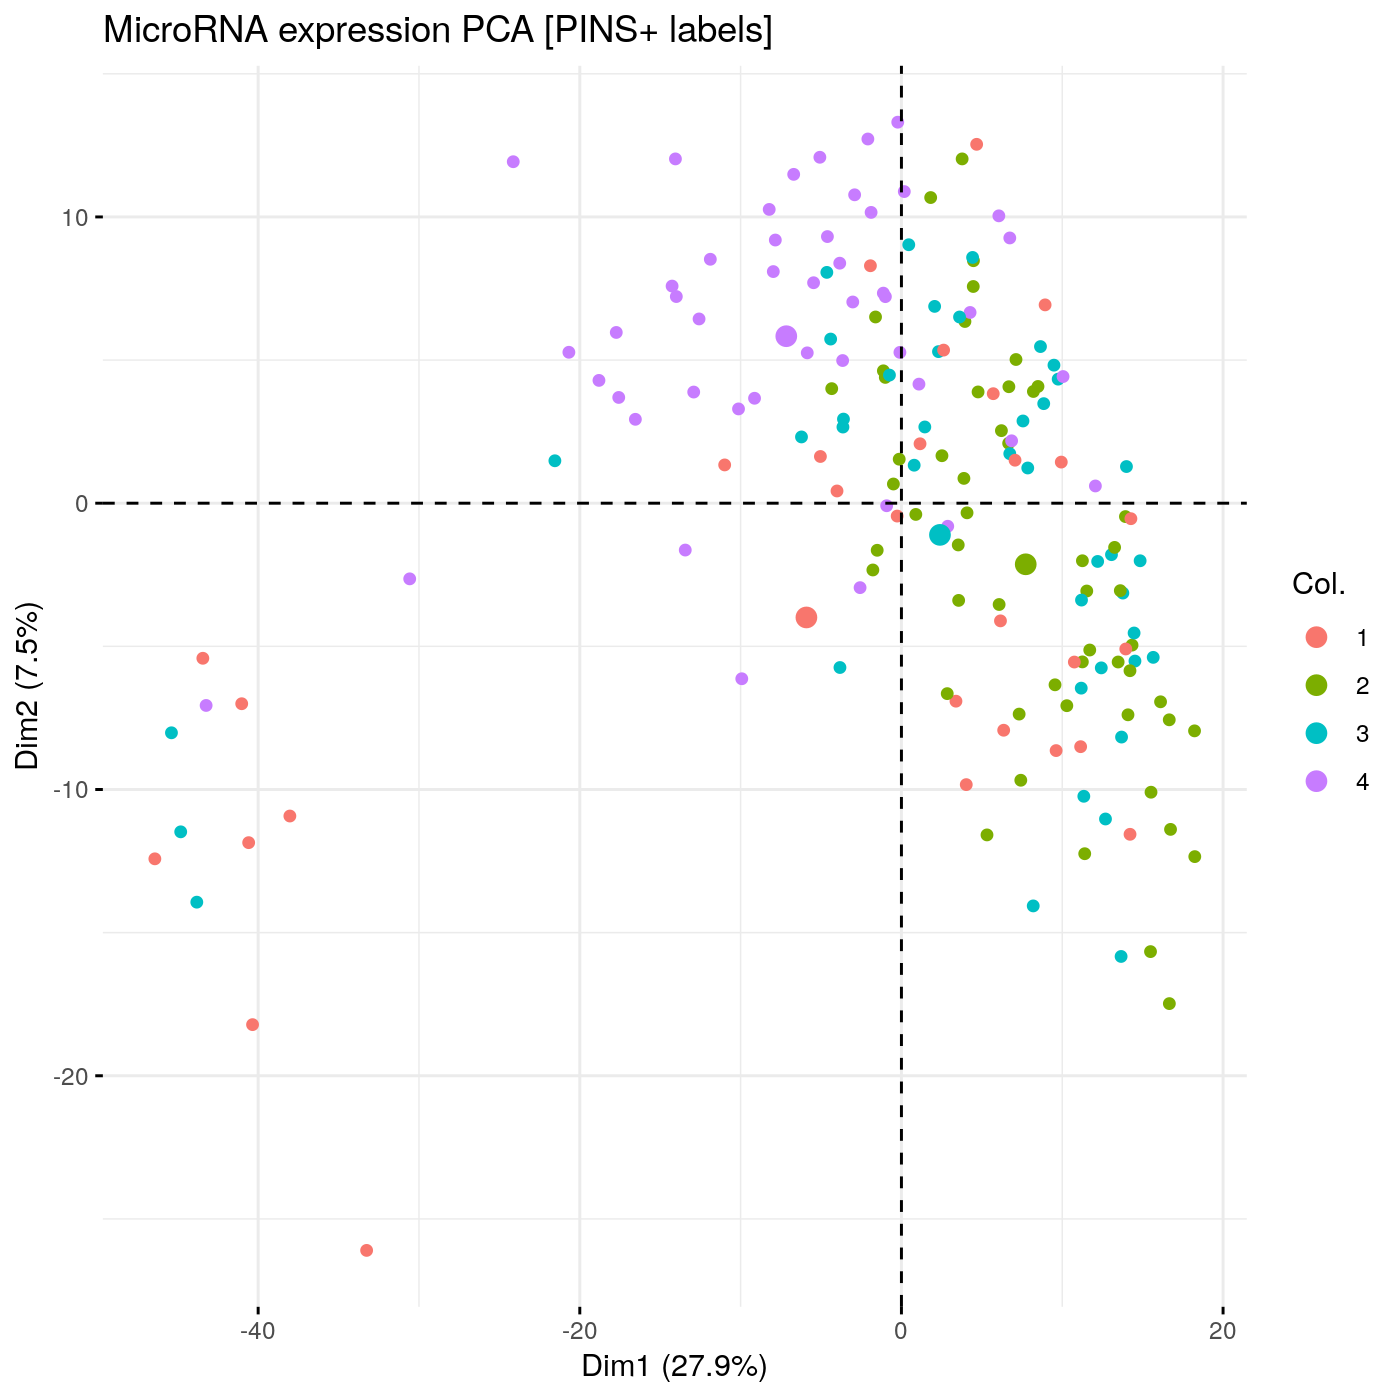

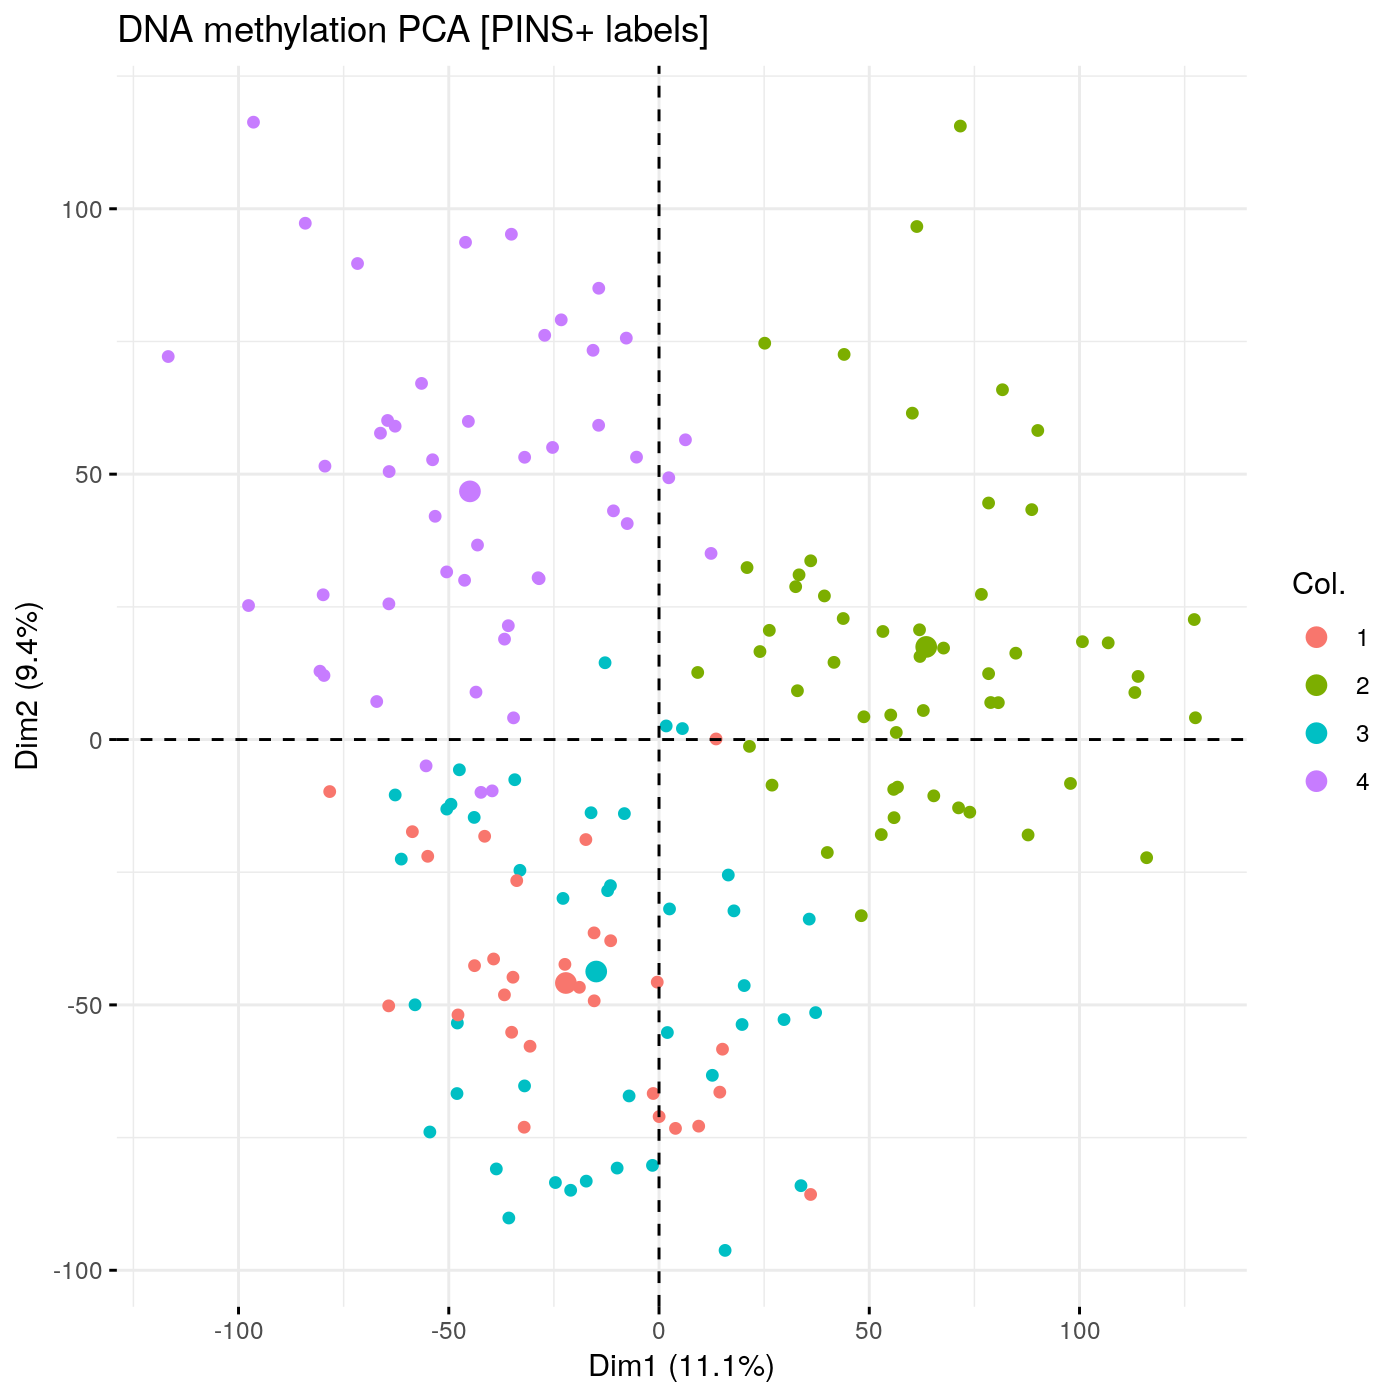

In [29]:
fviz_pca_ind(exp.pca, col.ind = factor(clustering2), geom="point", axes=c(1,2)) + 
    scale_shape_manual(values=rep(19, length(unique(clustering2)))) +
    labs(title="Gene expression PCA [PINS+ labels]")

fviz_pca_ind(mirna.pca, col.ind = factor(clustering2), geom="point", axes=c(1,2)) + 
    scale_shape_manual(values=rep(19, length(unique(clustering2)))) +
    labs(title="MicroRNA expression PCA [PINS+ labels]")

fviz_pca_ind(exp.pca, col.ind = factor(clustering2), geom="point", axes=c(1,2)) + 
    scale_shape_manual(values=rep(19, length(unique(clustering2)))) +
    labs(title="DNA methylation PCA [PINS+ labels]")

## (4) SUMO

SUMO is a novel method mulit-omic integration method that combines the omic-specific similarity driven approaches with the joint dimensionality reduction framework. 

First each omic is inspected separately and the pairwise distances between samples are calculated. The distance metric used by default is the Euclidean Distance, which is appropriate for **countinuous data types**, such as normalized count data and DNA methylation data we use in this tutorial. The calculated distances are then used to create the **data type specific similarity matrices** A_k, by applying the following radial basis function:

**A(i,j) = exp( -ρ^2(i,j) / με(i)ε(j) )**,

where:
- A(i,j) is the similarity between samples "i" and "j" in set data type,
- ρ(i,j) is the calculated distance between samples "i" and "j",
- μ - the hyperparameter of the kernel (by default 0.5),
- ε(i) - average distance between sample "i" and its "K" nearest neighbors (by default "K" is set to 10% of samples in the data type, however, if the number of clusters is know it should be set to #samples / #clusters).

Depending on the data type used different distance metric may be appropriate (for example, cosine similarity was found to better represent the similarities between cells in scATACseq). Alternative methods to create the similarity metrices implemented currently by SUMO include: cosine similarity, Pearson and Spearman correlation. If needed this framework can be extended by the implementation of custom similarity metric that follows the constrains of A_k(i,j) ∈ \[0,1\] and A_k(i,i) = 1, where "k" is used as an index for the data type.


After the creation of omic-specific similarity matrices, all of them are **jointly factorized**, by the variant of **symmetric non-negative matrix factorization (NMF)**. The symmetric NMF is the modification of the general matrix factorization formulation *X ≈ WH* (which we saw in the "MFA" section of this tutorial), where the decomposition is done on the symmetric matrix of non-negative values to improve the clustering quality. As the pairwise-sample similarity matrices meet these requirements, the Symmetric NMF could be formulated as: *A ≈ HH^T*.

To integrate the separet similarity matrices SUMO further extends this formulation to:

**A(i) ≈ H S(i) H^T**,

where:
- H (n x k) is a non-negative decomposition shared between the data types and represents the "n" samples in a "k"-dimentional space that accounts for the similarities in all the omics,
- S(i) (k x k) is a data type specific non-negative matrix accounting for the relationships between clusters of samples in set omic,
- "i" here is used as an index for the data type,
- "k" is the factorization rank / the desired number of clusters.

The above factorization is computed by minimizing the following objective function:
<img src="img/sumo_cost.png" width=50%>

As discussed in the "MFA" section this cost function includes the regularization term that imposes the sparsity of the H matix. Moreover, the introduced W(i) matrices (a data-type specific binary indicator matrices) are used to "mask" the values in similarity matrices if the distance between a pair samples could not be calculated correctly, i.e. if either the sample is missing from one of the data-types or due to many missing feature values the accuracy of the distance calculation is lowered. Thus, SUMO can handle both missing samples and missing feature values, with **no need for data imputation** and **no additional feature selection**.

The minimalization of above objective function is a general optimization problem, that can be solved by the application of multiplicative update rules, briefly:

- the H and S(i) values are initialized,
- S(i) values are updated while H is fixed,
- H values are updated while S(i) is fixed,
- cost function value is calculated,
- the matrices are alternatively updated until the change of cost function is very small or the pre-set maximum number of iteration is reached.

The sample labels are recoverd from H matrix, by applying the maximum value criterium (finding which column/cluster have the maximum value for each sample).

It is important to note that this cost function is non jointly convex and as such we are not guaranted to reach the global minimum, by following above steps and is sensitive to initial conditions. To deal with this problem SUMO implements a series of improvements:
- initial values of H and S(i) are not fully random, but partially set using an SVD-based approach according to average similarity across the data types;
- the factorization is run multiple times with differently initialized matrices;
- sample labels recovered from each factorization run are used to create a **consensus matrix** (weighted by the residual error of each run) and final sample labels are recovered from the consensus matrix using the Normalized Cut algorithm.
- finally, to improve the robustness of resulting clusters SUMO implements the **subsampling approach**, where each factorization is run for a subset of samples.

<img src="img/sumo_workflow.png">

### Data pre-processing

SUMO is a command-line package writen in python. The data pre-processing process includes following steps:
- (Optional) data filtering - It is recommended to remove the non-informative features (which we did during data exploration) and features with large fraction of missing values to speed up the computation. An example of different filtering criterium is the removal of genes that are not protein coding.
- Data transformation - This step depends on the data type used. For the count data we alredy perforemed the log transformation, which is sufficient. For the methylation data (as recommended in [SUMO documentation](https://python-sumo.readthedocs.io/en/latest/example.html#data-preprocessing)) we will transform beta-values into M-values, so a log2 ratio of the methylated to unmethylated counts.
- Data normalization - Here, we perform the feature-wise (z-score) standardization.

In [30]:
normalize.matrix <- function(data.matrix) {
  num = data.matrix - rowMeans(data.matrix, na.rm=TRUE)
  return((num / apply(num, 1, function(x) sd(x, na.rm=TRUE))))
}
                      
# prepare gene expression
data_exp_norm <- normalize.matrix(data_exp)   
# prepare miRNA expression
data_mirna_norm <- normalize.matrix(data_mirna)   
# prepare DNA methylation
eps = .Machine$double.eps
data_Mval <- log2(data_met + eps) / (1 - data_met + eps)
data_Mval_norm <- normalize.matrix(data_Mval)
                      
# save data matrices into tab-delimited files
write.table(data_exp_norm, file = file.path(data_dir_path, "exp_sumo.tsv"), sep = "\t",
            row.names = TRUE, col.names = TRUE,)
write.table(data_mirna_norm, file = file.path(data_dir_path, "mirna_sumo.tsv"), sep = "\t",
            row.names = TRUE, col.names = TRUE,)
write.table(data_Mval_norm, file = file.path(data_dir_path, "met_sumo.tsv"), sep = "\t",
            row.names = TRUE, col.names = TRUE,)

### SUMO prepare

**REMEMBER: Run all SUMO commands listed belo using command-line from the main directory of this repository.**

Here is how you can run SUMO in **prepare** mode to generate similarity matrices:

SUMO created an .npz file containing the multiplex similarity network and plotted the similarity matrices. 
Let's inspect them closer in R. Can we see the groups of samples separating together in different data types?

In [31]:
# how to read .npz files in R with reticulate
np <- import("numpy")
npz <- np$load("aml/prepared.aml.npz", allow_pickle=TRUE)
npz$files

Warning message:
“Python '/home/sienkie/.pyenv/shims/python3' was requested but '/opt/python/3.6.6/bin/python3.6' was loaded instead (see reticulate::py_config() for more information)”


[1] "0"       "f0"      "1"       "f1"      "2"       "f2"      "samples"

In [32]:
# here is the similarity matrix for first data type (in order given to sumo prepare)
exp_sim <- npz$f[['0']]
met_sim <- npz$f[['1']]
mirna_sim <- npz$f[['2']]
sample_order <-  npz$f[['samples']]
head(exp_sim) # rows full of NaN values indicate samples missing from this data type

[,1] [,2]       [,3] [,4]       [,5]       [,6]       [,7]       [,8]
[1,] NaN         NaN NaN         NaN        NaN        NaN        NaN NaN 
[2,] NaN  1.00000000 NaN  0.02929302 0.03855912 0.03231121 0.05847803 NaN 
[3,] NaN         NaN NaN         NaN        NaN        NaN        NaN NaN 
[4,] NaN  0.02929302 NaN  1.00000000 0.05705134 0.05500248 0.09151550 NaN 
[5,] NaN  0.03855912 NaN  0.05705134 1.00000000 0.04514824 0.12572738 NaN 
[6,] NaN  0.03231121 NaN  0.05500248 0.04514824 1.00000000 0.06065847 NaN 
     [,9]       [,10]       [,11] [,12]      [,13]      [,14]      [,15]     
[1,]        NaN         NaN ⋯            NaN        NaN        NaN        NaN
[2,] 0.06743043 0.021268101 ⋯     0.04448786 0.08205528 0.03582751 0.04165080
[3,]        NaN         NaN ⋯            NaN        NaN        NaN        NaN
[4,] 0.01213601 0.005266699 ⋯     0.04369068 0.02431377 0.04796955 0.01426185
[5,] 0.01291242 0.002833459 ⋯     0.05291604 0.03784362 0.03150906 0.01362028
[6,] 0.03469878 0.009814405 ⋯     0.03823101 0.06855619 0.19355499 0.02510034
     [,16]      [,17]      [,18]      [,19]      [,20]      [,21]     
[1,]        NaN        NaN        NaN        NaN        NaN        NaN
[2,] 0.03930527 0.07957235 0.03434898 0.03771610 0.04253075 0.12082226
[3,]        NaN        NaN        NaN        NaN        NaN        NaN
[4,] 0.02484474 0.02009244 0.02160733 0.04580228 0.02546840 0.01921831
[5,] 0.05199814 0.04313639 0.04950704 0.06542718 0.03540070 0.03532830
[6,] 0.05179714 0.04134428 0.06353640 0.07458380 0.06315281 0.05219601

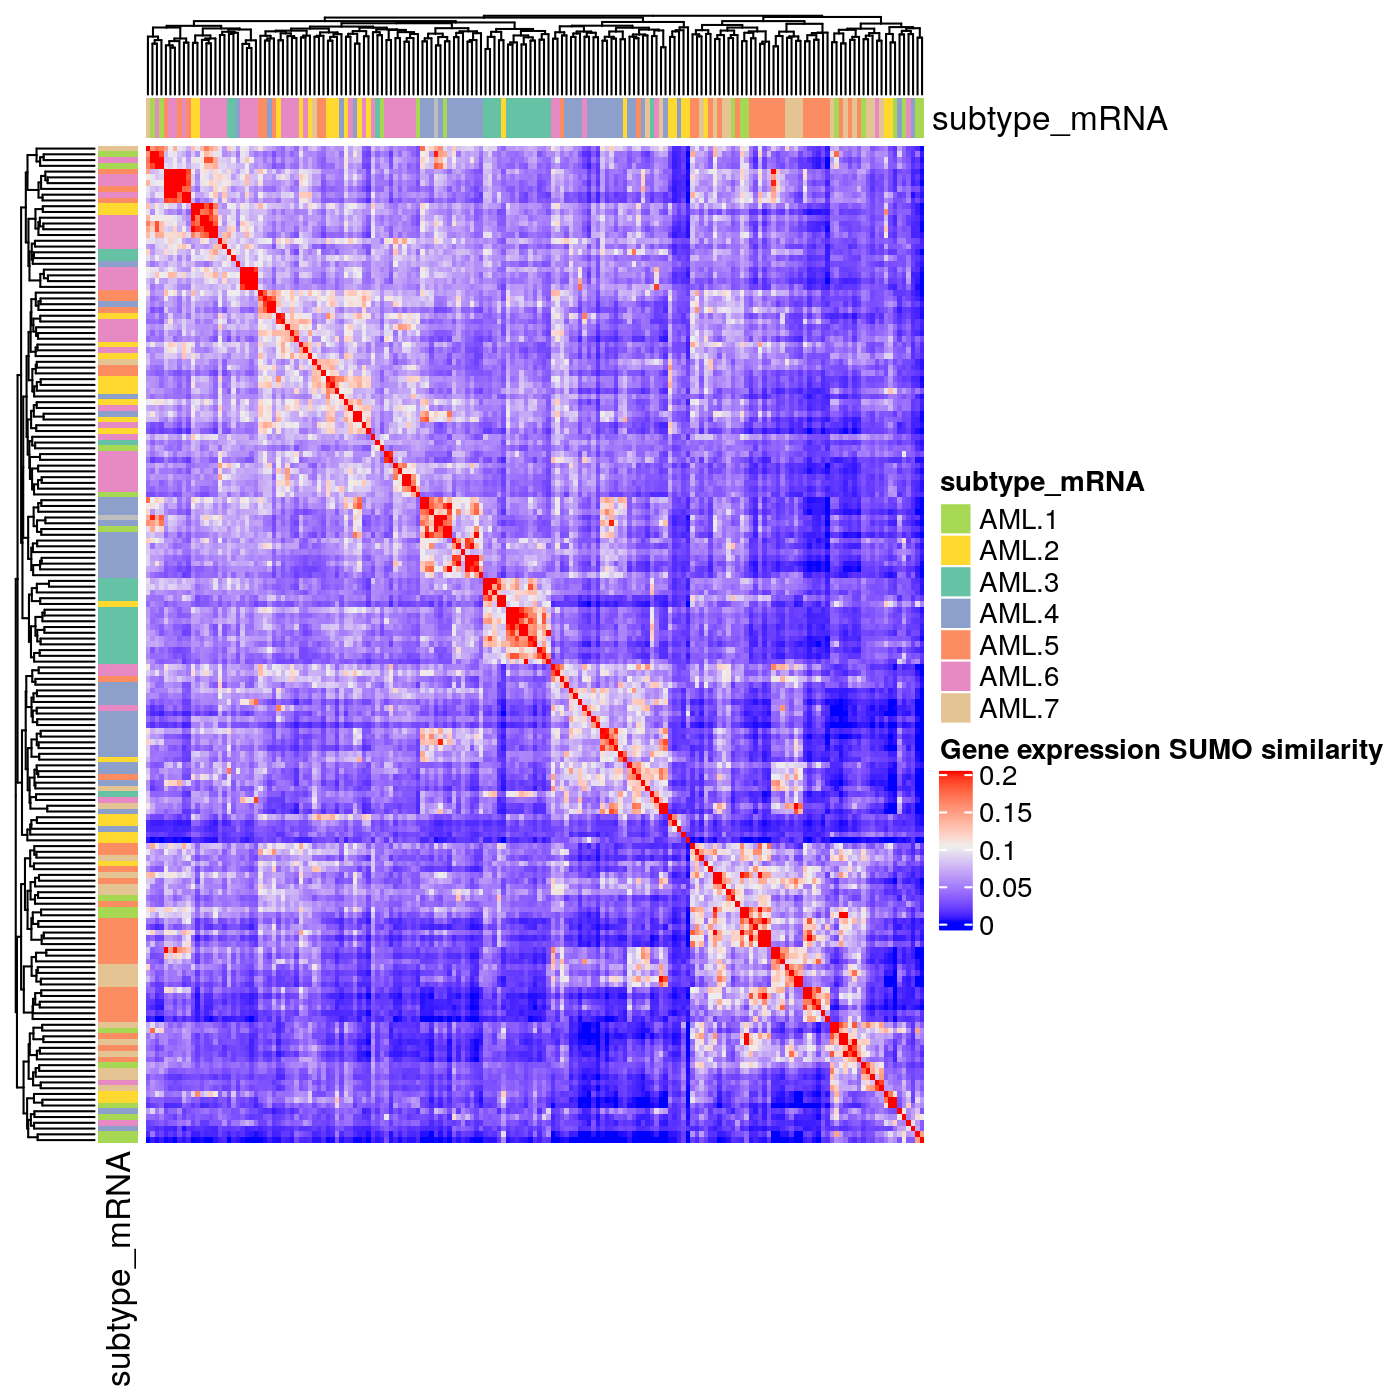

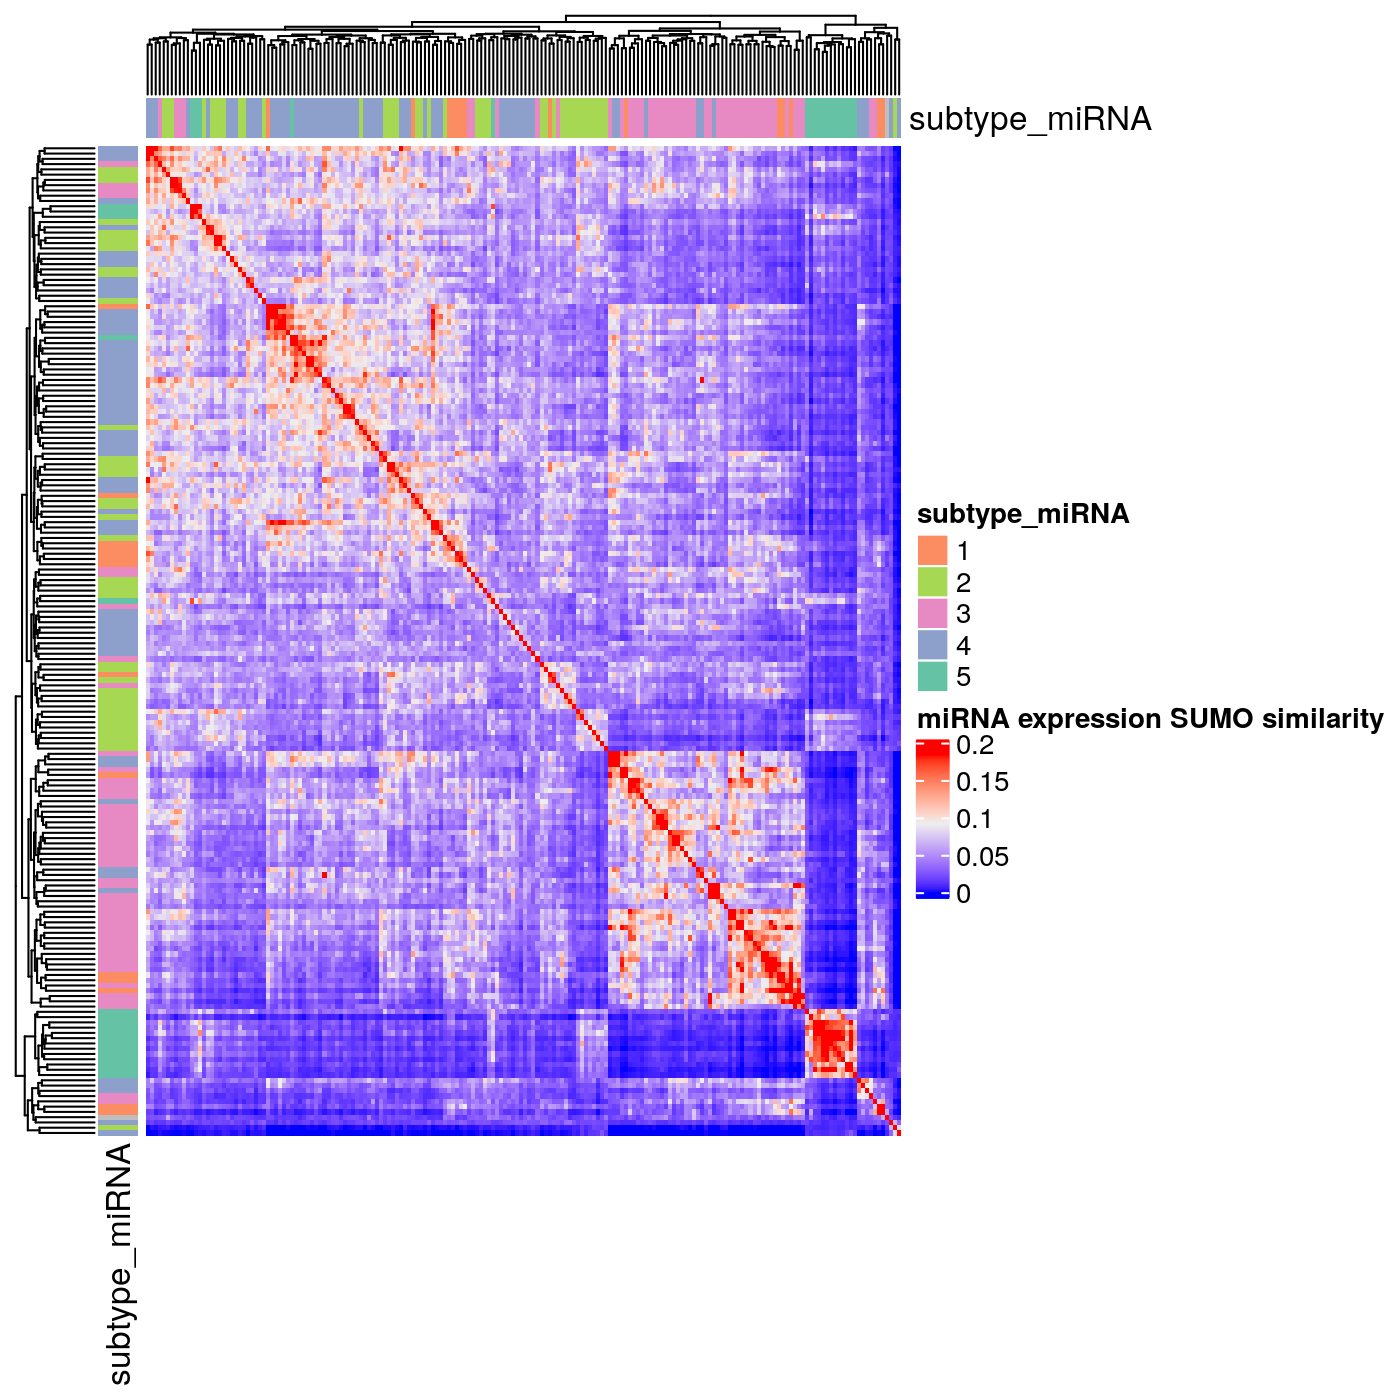

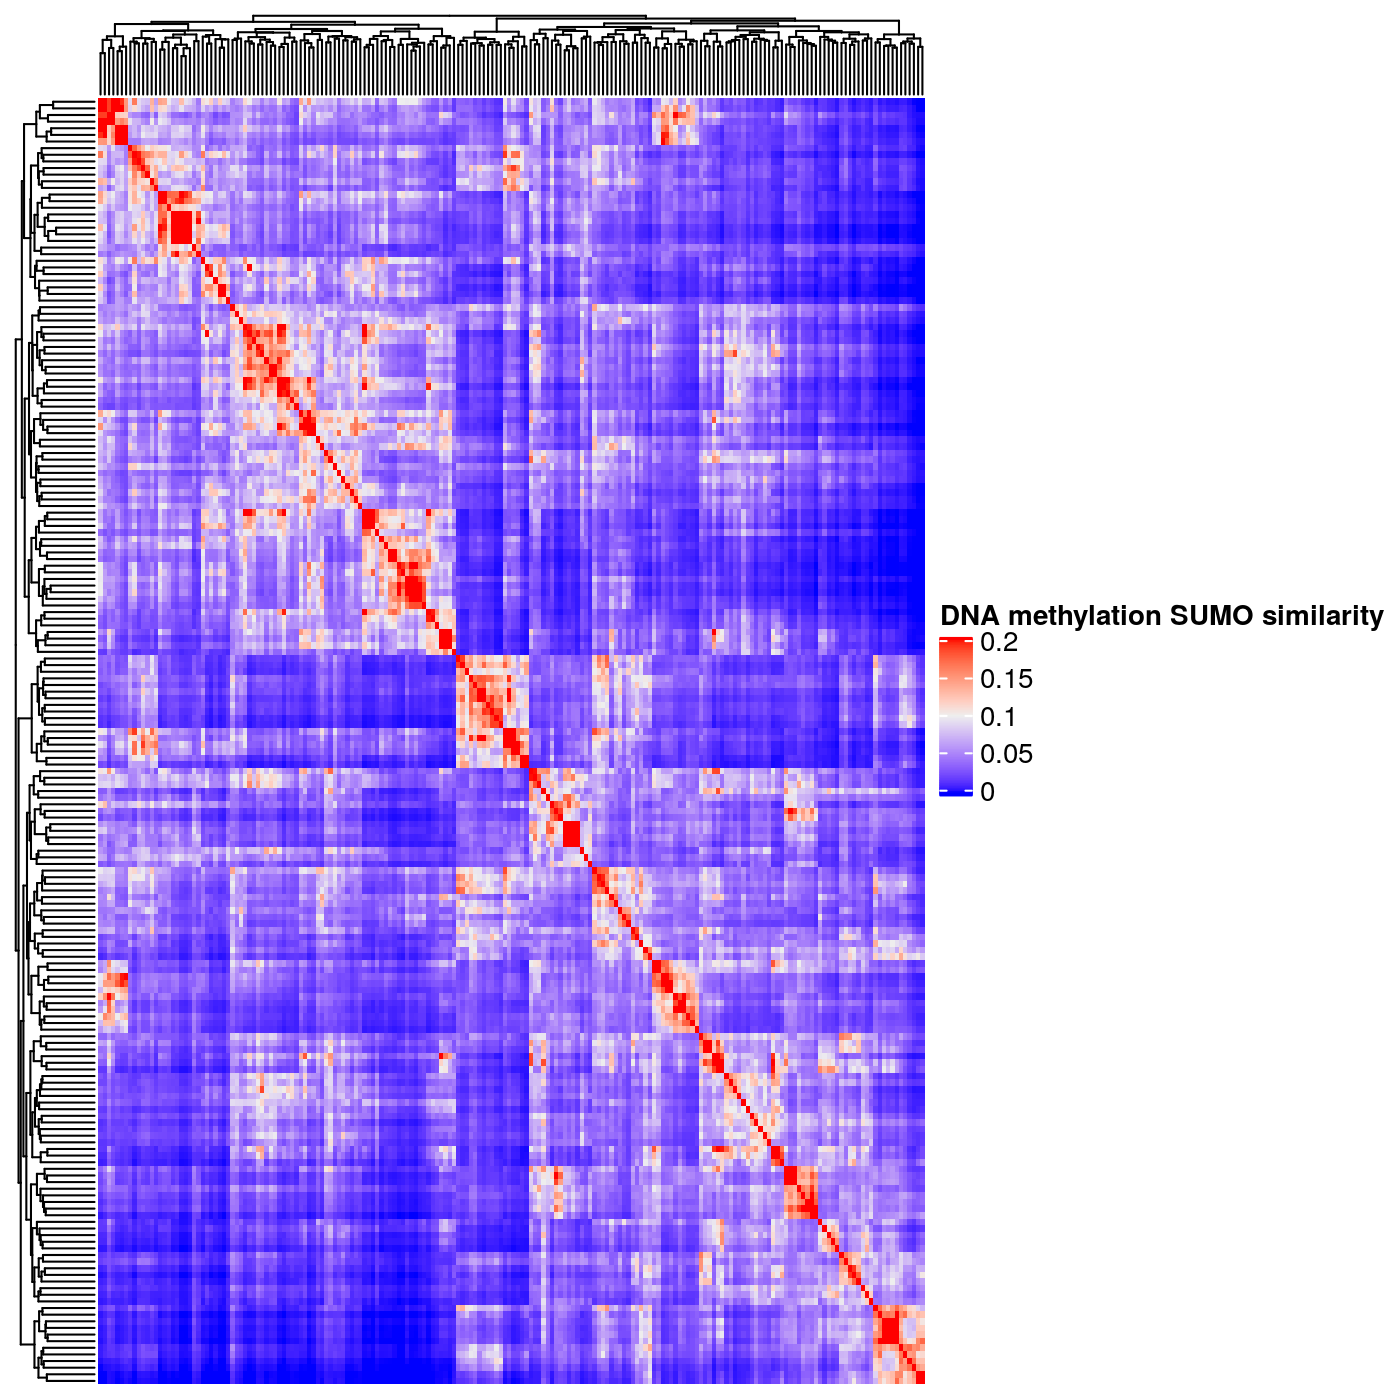

In [33]:
rownames(exp_sim) <- sample_order
colnames(exp_sim) <- sample_order
# remove missing samples from the matrix for the visualization
avail_samples <- colnames(exp_sim)[rowSums(is.na(exp_sim)) != dim(exp_sim)[1]]

exp_subtypes <- tibble(sample_codes=avail_samples) %>% 
    left_join(subtypes_data, by = "sample_codes") # in order of avail_samples

h <- Heatmap(exp_sim[avail_samples, avail_samples], show_row_names=FALSE, show_column_names=FALSE,
        name="Gene expression SUMO similarity", 
        top_annotation=HeatmapAnnotation(subtype_mRNA=exp_subtypes$Subtype_Selected,
                                         col = list(subtype_mRNA=exp_subtypes_col)),
        left_annotation=rowAnnotation(subtype_mRNA=exp_subtypes$Subtype_Selected,
                                         col = list(subtype_mRNA=exp_subtypes_col))
)
draw(h, merge_legend=TRUE)

rownames(mirna_sim) <- sample_order
colnames(mirna_sim) <- sample_order
# remove missing samples from the matrix for the visualization
avail_samples <- colnames(mirna_sim)[rowSums(is.na(mirna_sim)) != dim(mirna_sim)[1]]

mirna_subtypes <- tibble(sample_codes=avail_samples) %>% 
    left_join(subtypes_data, by = "sample_codes") # in order of avail_samples

h <- Heatmap(mirna_sim[avail_samples, avail_samples], show_row_names=FALSE, show_column_names=FALSE,
        name="miRNA expression SUMO similarity", 
        top_annotation=HeatmapAnnotation(subtype_miRNA=mirna_subtypes$Subtype_miRNA,
                                         col = list(subtype_miRNA=miRNA_subtypes_col)),
        left_annotation=rowAnnotation(subtype_miRNA=mirna_subtypes$Subtype_miRNA,
                                         col = list(subtype_miRNA=miRNA_subtypes_col))
)
draw(h, merge_legend=TRUE)

rownames(met_sim) <- sample_order
colnames(met_sim) <- sample_order
# remove missing samples from the matrix for the visualization
avail_samples <- colnames(met_sim)[rowSums(is.na(met_sim)) != dim(met_sim)[1]]

Heatmap(met_sim[avail_samples, avail_samples], show_row_names=FALSE, show_column_names=FALSE,
        name="DNA methylation SUMO similarity")

### SUMO run

Here is how you can run SUMO to integrate and factorize created similarity matrices if the number of clusters is known.

In [34]:
np <- import("numpy")
npz <- np$load(file.path(data_dir_path,'sumo_k7','k7','sumo_results.npz'), allow_pickle=TRUE)
npz$files

[1] "pac"                  "cophenet"             "clusters"            
[4] "consensus"            "unfiltered_consensus" "quality"             
[7] "samples"              "config"               "steps"

We can find two consensus matrices in this file: the unfiltered version and 'consensus', where all values lower then 0.5 where substituted to 0. SUMO uses the filtered version to find final sample labels. 
However, when making comparisons between different SUMO clusterings (see next section of this tutoral) the unfiltered version should always be used.

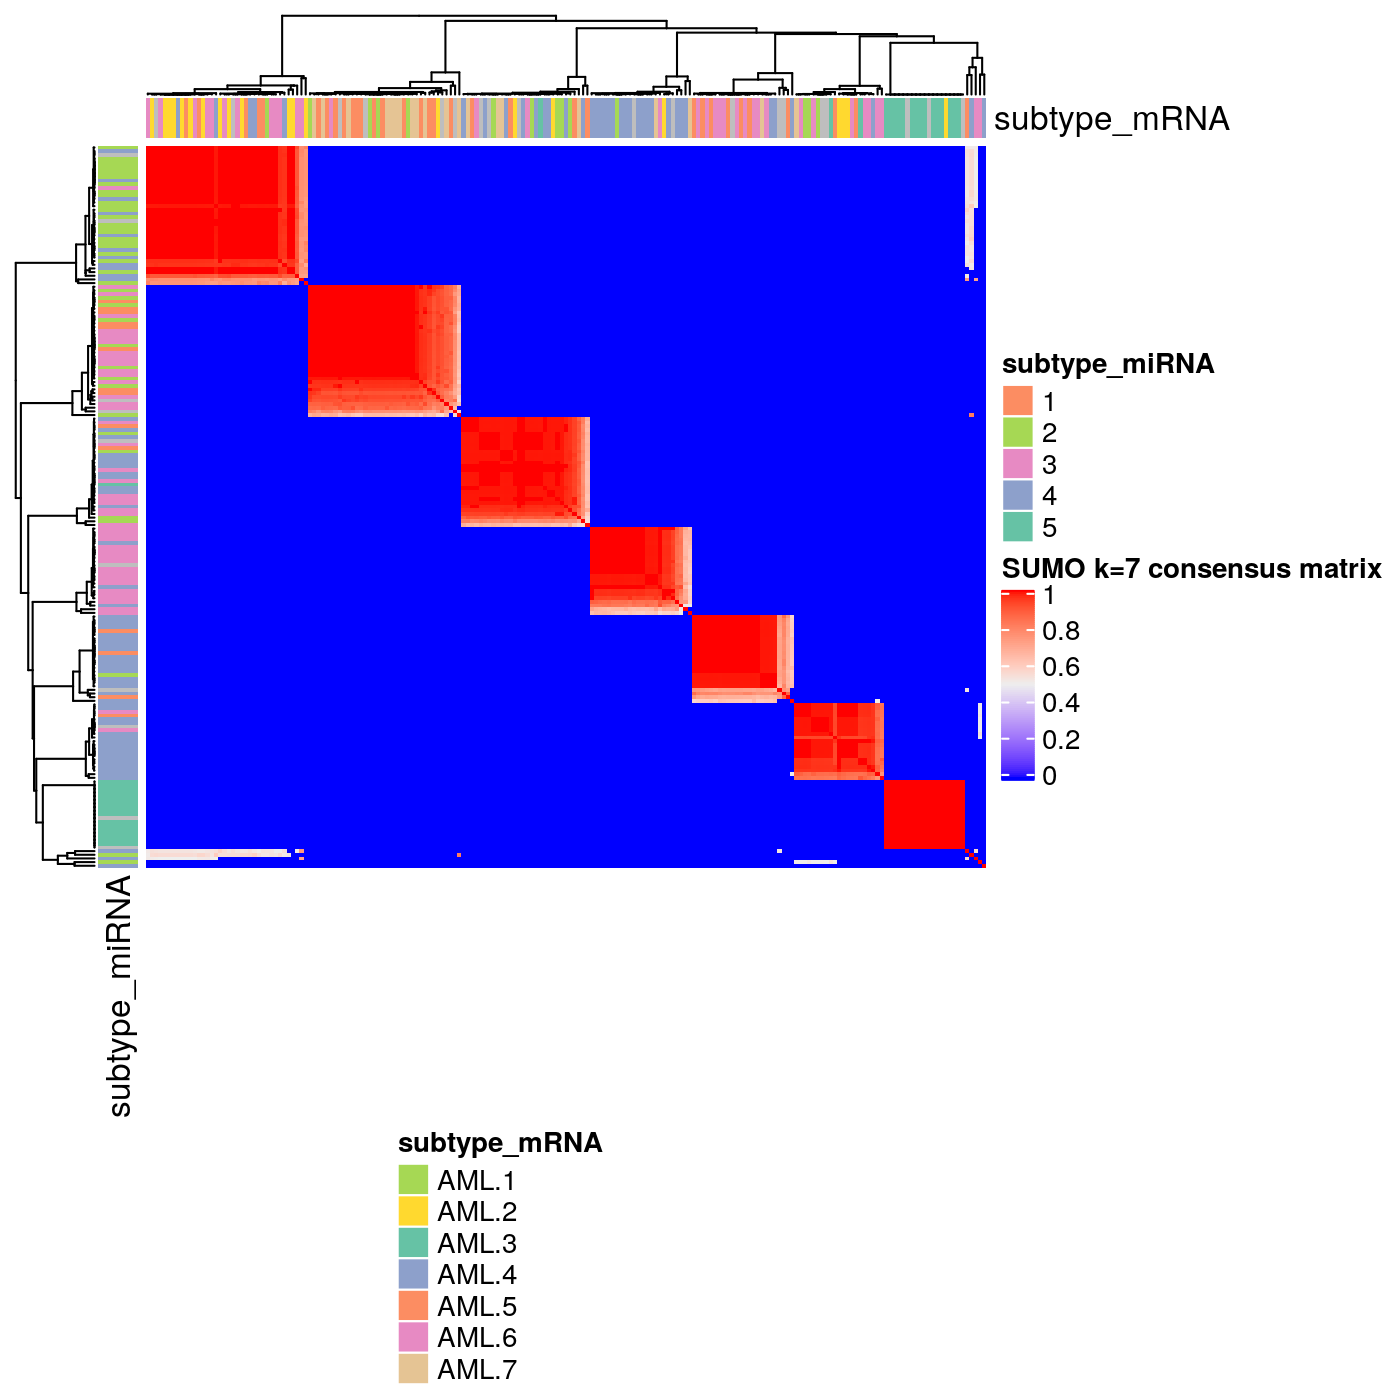

In [35]:
sample_order <-  npz$f[['samples']]
con <- npz$f[['consensus']]
rownames(con) <- sample_order
colnames(con) <- sample_order
con_subtypes <- tibble(sample_codes=sample_order) %>% 
    left_join(subtypes_data, by = "sample_codes") # in order of sample_order

h <- Heatmap(con, show_row_names=FALSE, show_column_names=FALSE,
        name="SUMO k=7 consensus matrix", 
        top_annotation=HeatmapAnnotation(subtype_mRNA=con_subtypes$Subtype_Selected,
                                         col = list(subtype_mRNA=exp_subtypes_col)),
        left_annotation=rowAnnotation(subtype_miRNA=con_subtypes$Subtype_miRNA,
                                         col = list(subtype_miRNA=miRNA_subtypes_col))
)
draw(h, annotation_legend_side="bottom")

The clusters are pretty well estabilished (so robust, regardless of the subsampling). We can observe the interplay between the miRNA and gene expression in driving the cluster separtion. The cluster supported by both data types (AML.3/miRNA#5 which we observed previously) is separated. We can also observe a separation of a cluster of samples driven fully by miRNA (#2). A noteworthy amount of samples form miRNA cluster #4 is separating into 2 clusters. As separation of this two groups does not seem to be driven by gene expression, it is possible that the separation is apearing due to the methylation. Finally, even though the most commonly use TCGA classification is based on gene expression with k=7. However, running SUMO (with the same set number of clusters) on the integrated dataset we recieve clusters that not only does not recapitulate the subtypes perfectly, but also seem be significantly driven by miRNA subtypes. 

### How many sample clusters are in our data?

The estimation of the number of sample clusters "k" in the dataset (so the "factorization rank") is a challenging problem. Again, it is recommend to run the method for a broad range of possible "k" values and compare the robustness of resulting clusters. For this purpose SUMO implements two metrics:
- Cophenetic Correlation Coefficient (CCC) - a common metric for the NMF models, which measures the Pearson correlation between sample distances and its hierarchical clustering (we look for a high CCC value, typically > 0.95)
- Proportion of Ambiguously Clustered pairs (PAC) - this metric make use of SUMO subsampling approach, by counting the proportion of values in consensus matrix in (0.1, 0.9) range (we look for low PAC value, ideally < 0.1)

Here is how we can run SUMO for a range of "k" values. Notice the use of "-t" argument which allows for specifying the number of cores for parellel computing. This will most likely take a couple of minutes.

`summarise()` has grouped output by 'k'. You can override using the `.groups` argument.



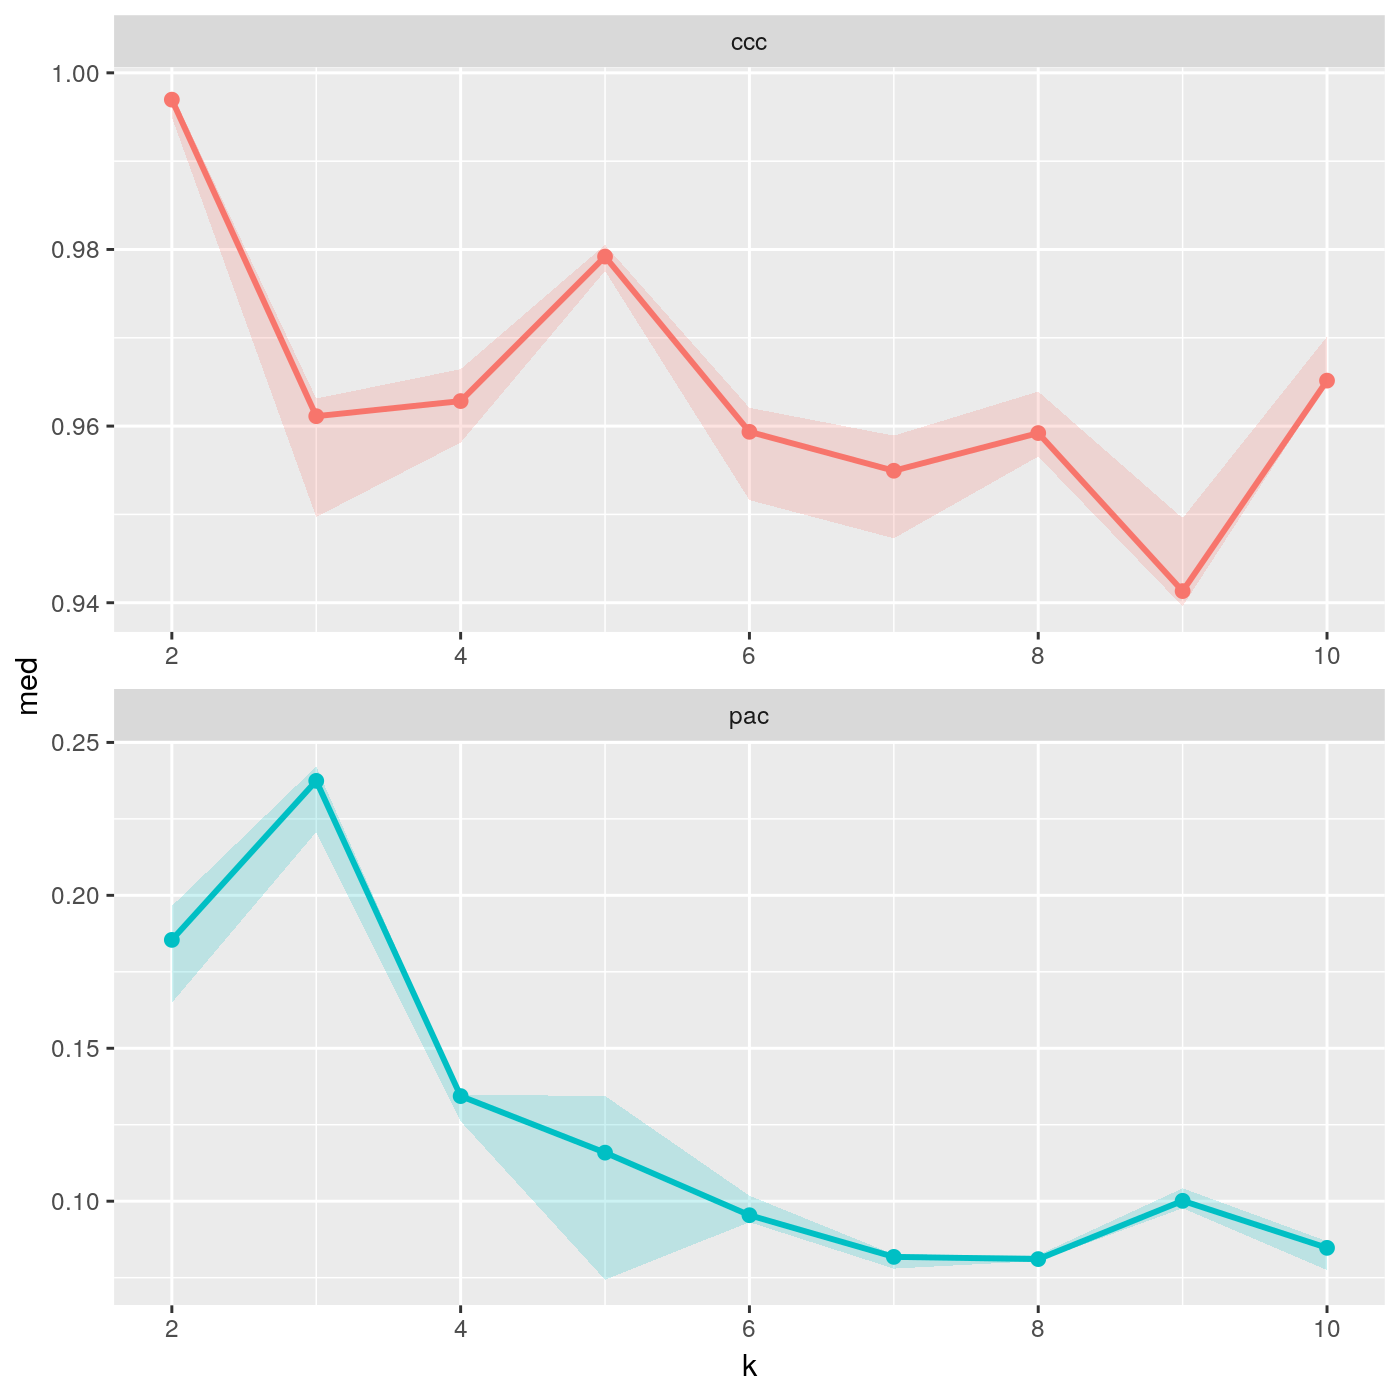

In [36]:
# let's plot the clustering metrics for all "k"
np <- import("numpy")

pac <- sapply(2:10, function(x){
    npz <- np$load(file.path(data_dir_path,'sumo', paste0('k', x),'sumo_results.npz'), allow_pickle=TRUE)
    return(npz$f[['pac']])
})

ccc <- sapply(2:10, function(x){
    npz <- np$load(file.path(data_dir_path,'sumo', paste0('k', x),'sumo_results.npz'), allow_pickle=TRUE)
    return(npz$f[['cophenet']])
})

colnames(pac) <- paste0(2:10)
pac <- as_tibble(pac) %>% gather(k, 'pac')
colnames(ccc) <- paste0(2:10)

as_tibble(ccc) %>% 
    gather(k, 'ccc') %>%
    full_join(pac, by = "k") %>%
    gather(metric, value, -k) %>%
    group_by(k, metric) %>%
    summarise(med=median(value), min=min(value), max=max(value)) %>%
    mutate(k=as.numeric(k)) %>%
    ggplot() +
    geom_line(aes(x=k, y=med, color=metric, group=metric), size=1) + 
    geom_point(aes(x=k, y=med, color=metric), size=2) + 
    geom_ribbon(aes(x=k, ymin=min, ymax=max, fill=metric), alpha=0.2) +
    facet_wrap(metric~., scales="free", ncol=1) +
theme(legend.position="null")

 It seems that both 7 and 8 are viable results. Let's compare these results:

`summarise()` has grouped output by 'sumo_label_k7'. You can override using the `.groups` argument.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


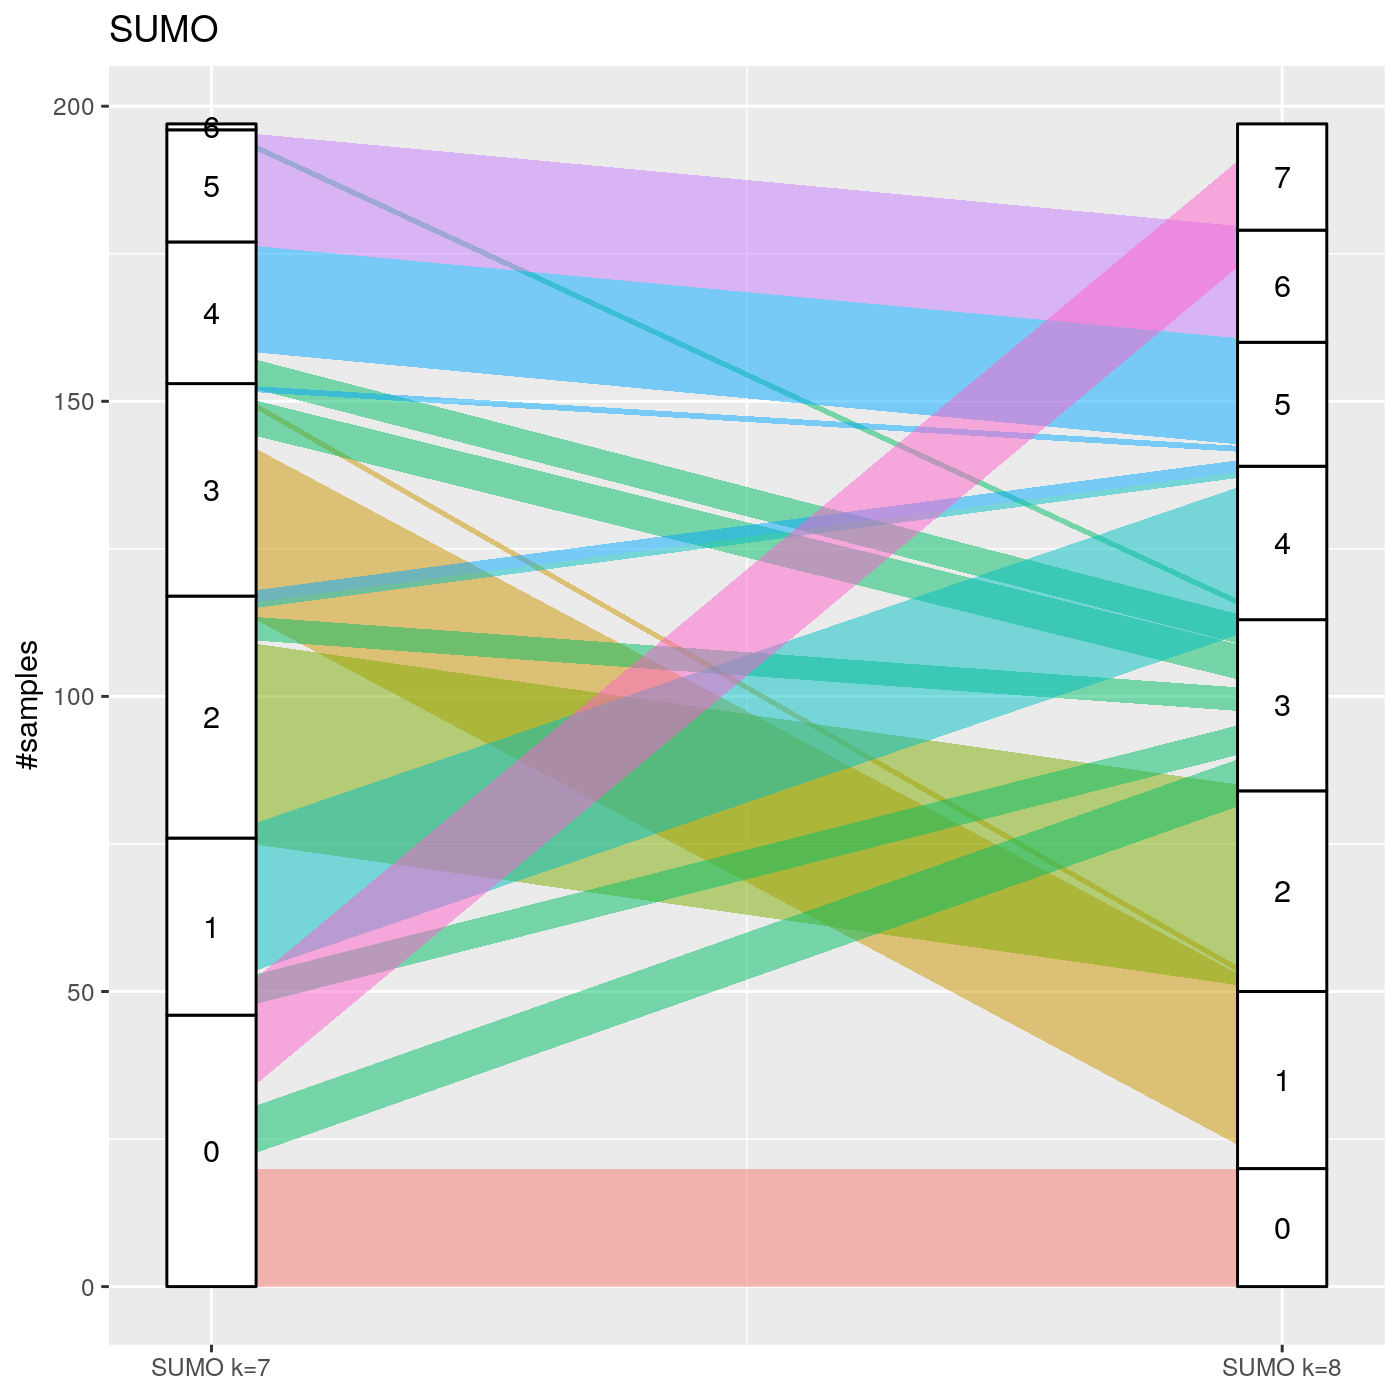

In [37]:
read_tsv(file.path(data_dir_path,'sumo', paste0('k', 7),'clusters.tsv'), show_col_types = FALSE)  %>%
    rename(sumo_label_k7=label) %>%
    full_join(read_tsv(file.path(data_dir_path,'sumo', paste0('k', 8),'clusters.tsv'), 
                       show_col_types = FALSE), by = "sample") %>%
    rename(sumo_label_k8=label) %>% 
    mutate(sumo_label_k7=as.factor(sumo_label_k7), sumo_label_k8=as.factor(sumo_label_k8)) %>%
    group_by(sumo_label_k7, sumo_label_k8) %>%
    summarise(nsamples=n()) %>%
    ggplot(aes(y=nsamples, axis1=sumo_label_k7, axis2=sumo_label_k8)) +
      geom_alluvium(aes(fill=sumo_label_k8), width = 0, knot.pos = 0, reverse = FALSE) +
      guides(fill = FALSE) +
      geom_stratum(width = 1/12, reverse = FALSE) +
      geom_text(stat = "stratum", aes(label = after_stat(stratum)),
                reverse = FALSE) +
      scale_x_continuous(breaks = 1:2, labels = c("SUMO k=7","SUMO k=8")) +
      labs(title="SUMO", y="#samples")

In [38]:
read_tsv(file.path(data_dir_path,'sumo', paste0('k', 7),'clusters.tsv'), show_col_types = FALSE)  %>%
    rename(sumo_label_k7=label) %>%
    group_by(sumo_label_k7) %>%
    summarise(nsample=n())

read_tsv(file.path(data_dir_path,'sumo', paste0('k', 8),'clusters.tsv'), show_col_types = FALSE)  %>%
    rename(sumo_label_k8=label) %>%
    group_by(sumo_label_k8) %>%
    summarise(nsample=n())

sumo_label_k7 nsample
1 0             46     
2 1             30     
3 2             41     
4 3             36     
5 4             24     
6 5             19     
7 6              1

sumo_label_k8 nsample
1 0             20     
2 1             30     
3 2             34     
4 3             29     
5 4             26     
6 5             21     
7 6             19     
8 7             18

This is a good result. It the wide "flow lines" above show that most of samples group into the same clusters for both k=7 and k=8. However one sample grouping into separate cluster for k=7 suggest slightly less stable result. Due to this we are going to proceed with k=8.

## Biological interpretation of results

In this section we are going to look into a couple of examples of downstrean analysis of multi-omic data integration and molecular subtyping.

### The Kaplan-Meier survival analysis

In [39]:
# read the survival data
surv_data <-read_tsv(file.path(data_dir_path, "survival"), show_col_types = FALSE)

surv_data <- surv_data %>% #unify sample ids
    separate(PatientID, c('tcga', 'tss', 'participant', 'st'), sep="-") %>%
    unite(c(tcga, tss, participant), col="samples", sep="-") %>%
    select(-st)

surv_data <- subtypes_data %>% 
    select(samples, Subtype_miRNA, Subtype_Selected) %>%
    left_join(surv_data, by = "samples") %>%
    distinct()
head(surv_data)
dim(surv_data)

samples      Subtype_miRNA Subtype_Selected Survival Death
1 TCGA-AB-2803 5             AML.3             792     1    
2 TCGA-AB-2805 1             AML.5             577     1    
3 TCGA-AB-2806 4             AML.4             945     1    
4 TCGA-AB-2807 4             AML.6             181     1    
5 TCGA-AB-2808 4             AML.5            2861     0    
6 TCGA-AB-2810 3             AML.1              31     1

[1] 197   5

First, let's see if the groups of samples separated by the TCGA samples are different in terms of survival.

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


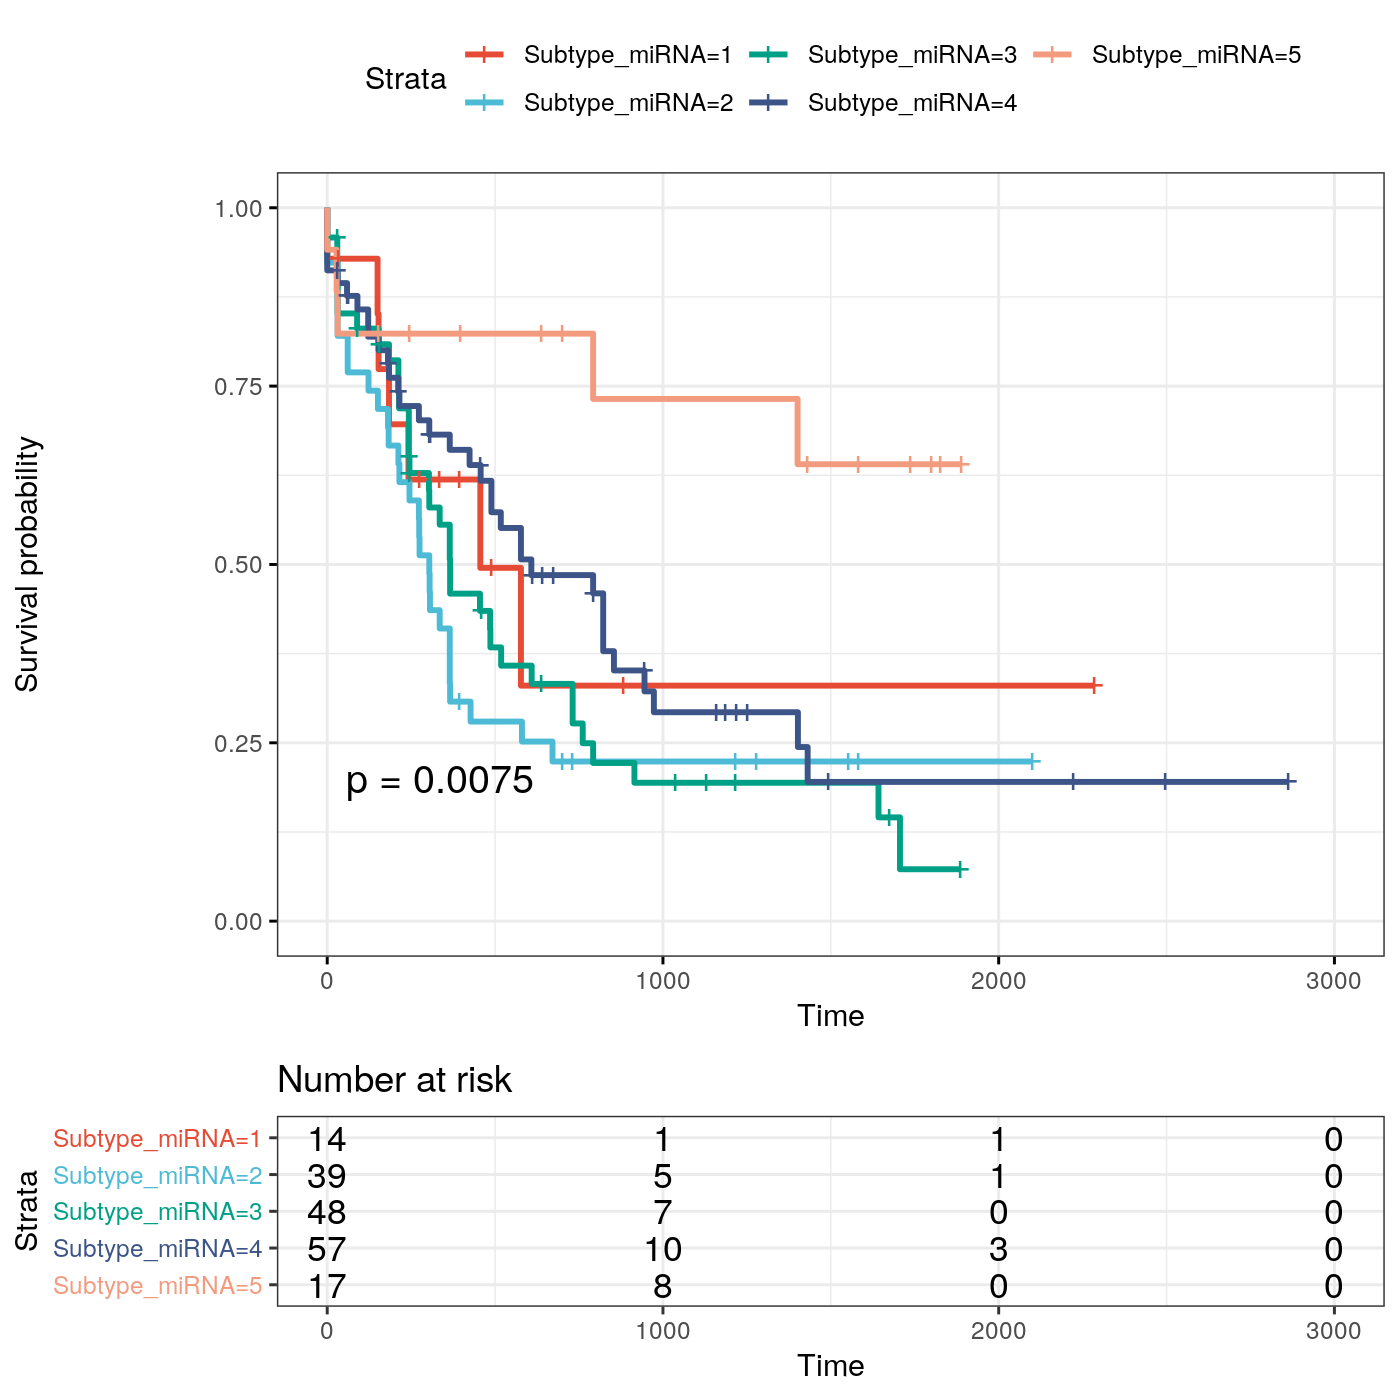

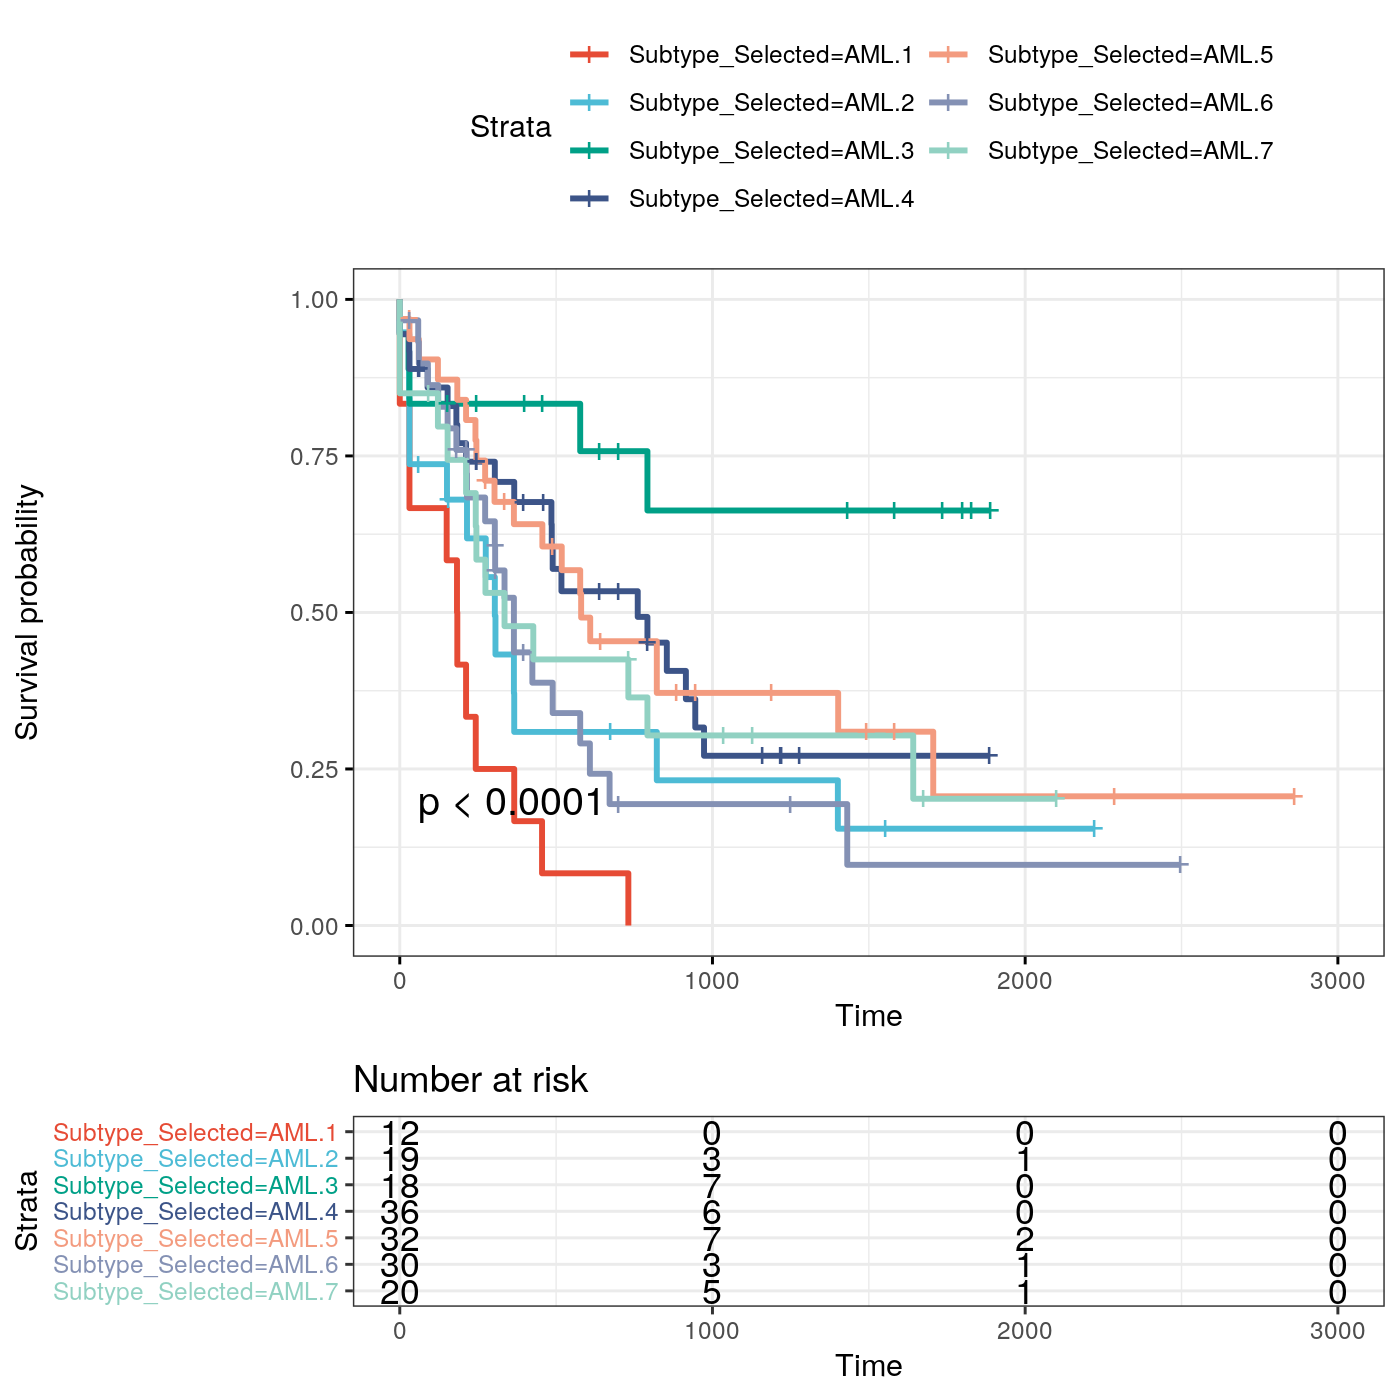

In [40]:
ggsurvplot(survfit(Surv(Survival, Death) ~ Subtype_miRNA, data=surv_data), 
           data=surv_data, 
           palette = "npg", 
           pval = TRUE,
           ggtheme = theme_bw(), 
           risk.table = TRUE) +
    guides(colour = guide_legend(nrow = 2))

ggsurvplot(survfit(Surv(Survival, Death) ~ Subtype_Selected, data=surv_data), 
           data=surv_data, 
           palette = "npg", 
           pval = TRUE,
           ggtheme = theme_bw(), 
           risk.table = TRUE) +
    guides(colour = guide_legend(ncol = 2))

Now let's investigate the recent SUMO clustering result

[1] 197   6

samples      label Subtype_miRNA Subtype_Selected Survival Death
1 TCGA-AB-2802 1      3            NA                365     1    
2 TCGA-AB-2803 6      5            AML.3             792     1    
3 TCGA-AB-2804 6     NA            NA               2557     0    
4 TCGA-AB-2805 3      1            AML.5             577     1    
5 TCGA-AB-2806 3      4            AML.4             945     1    
6 TCGA-AB-2807 2      4            AML.6             181     1

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


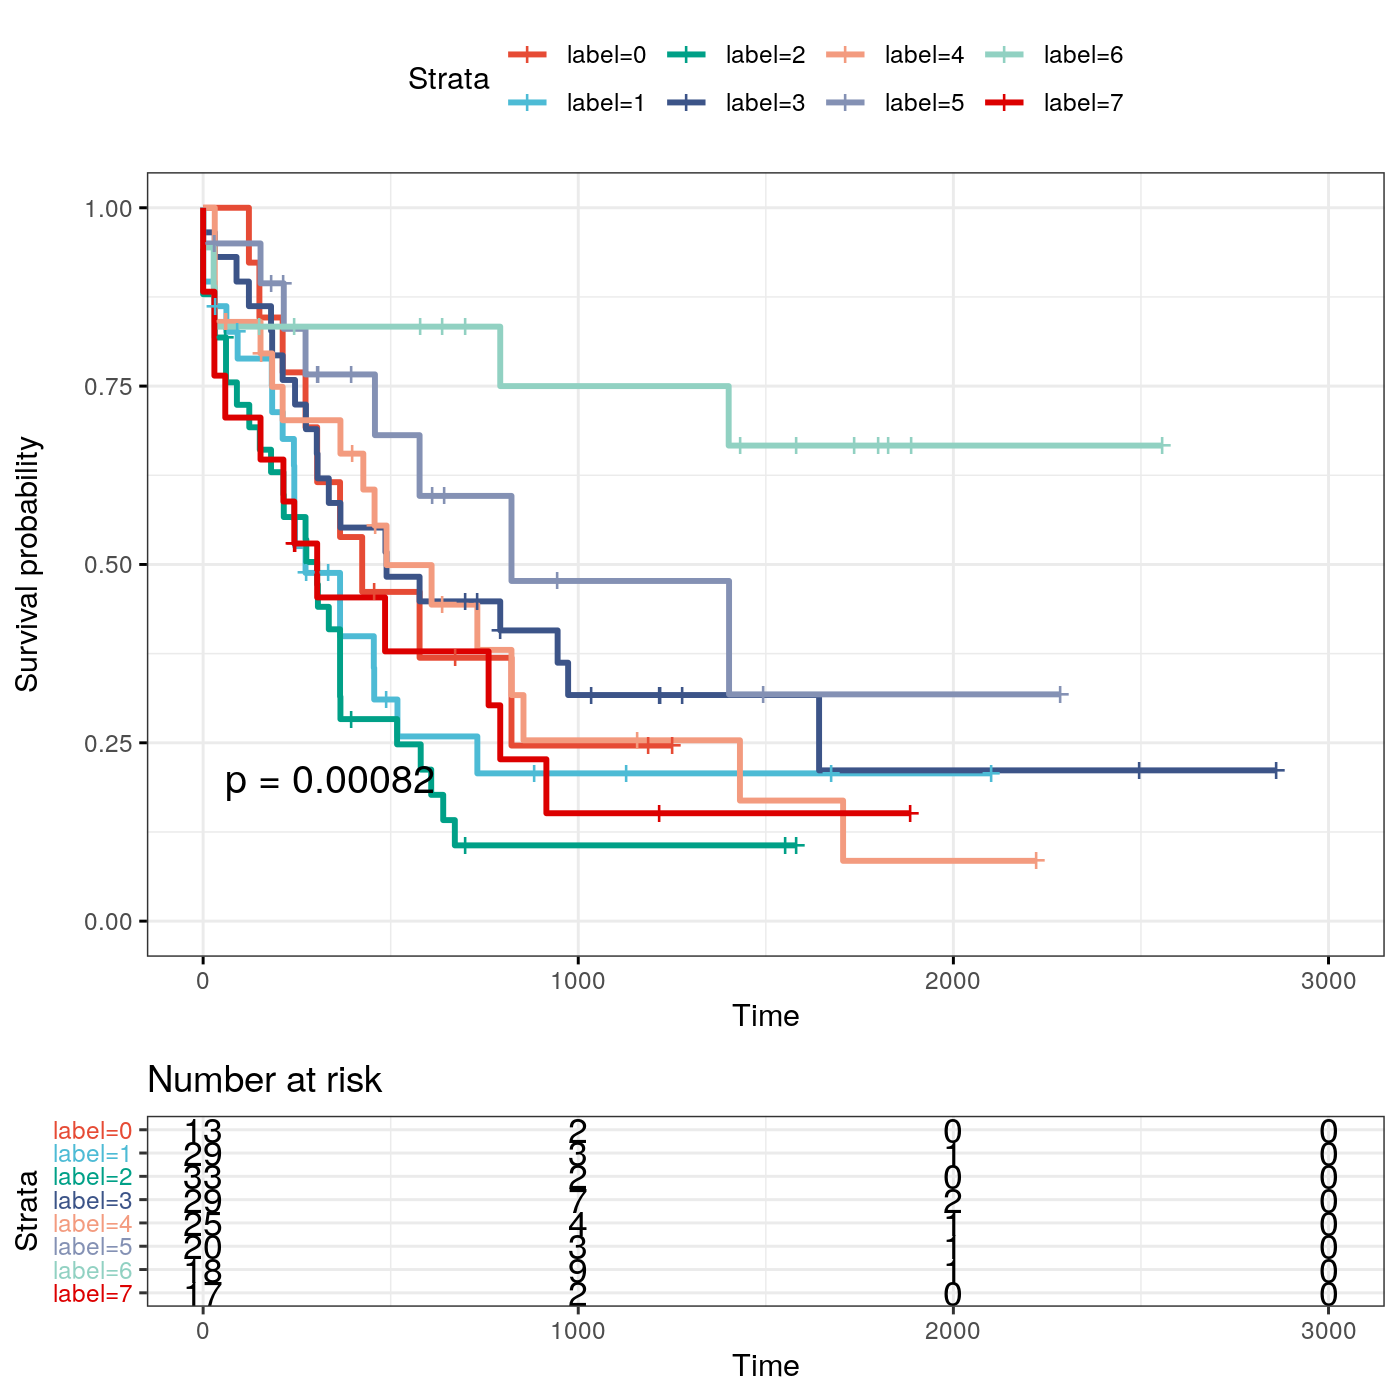

In [41]:
sumo_labels <- read_tsv(file.path(data_dir_path, "sumo", 'k8', 'clusters.tsv'), show_col_types = FALSE) %>%
    separate(sample, c('tcga', 'tss', 'participant', 'st'), sep="\\.") %>%
    unite(c(tcga, tss, participant), col="samples", sep="-") %>%
    select(-st) %>%
    left_join(surv_data, by = "samples") 
dim(sumo_labels)
head(sumo_labels)

ggsurvplot(survfit(Surv(Survival, Death) ~ label, data=sumo_labels), 
           data=sumo_labels, 
           palette = "npg", 
           pval = TRUE,
           ggtheme = theme_bw(), 
           risk.table = TRUE) +
    guides(colour = guide_legend(nrow = 2))

The p-value of log-rank test reported in case of both TCGA subtypes and SUMO clusters is very significant, which means that in all cases there is at least one group of samples with significantly different survival. In case of TCGA subtypes it is the previously observed miRNA\#5/AML.3 subtype of samples. As shown below, almost all of those samples are grouped in the same cluster by SUMO.

In [42]:
sumo_labels %>% 
    filter(Subtype_miRNA==5 & Subtype_Selected=="AML.3") %>%
    group_by(label) %>%
    summarise(n_samples=n())

label n_samples
1 4      1       
2 6     15

It is important to note that biologically different subtypes (for example samples with very different pathway activity) may **not always show the differences in survival**. Additionnaly, this metric may be biased due to the differences in the patient treatment history.

### Feature analysis

Identification of features correlationg with the cluster separation is a frequent goal of multi-omics data integration. These features can help to understand the source of the differences between the groups of samples and facilitate the discovery of novel biomarkers of the disease. 

#### Feature weights and loading vectors

The most straightforward way to go about interpreting the latent factors in a biological context, is to look at the coefficients which are associated with them. For latent variable models that take the linear form  **X ≈ WH** we want to investigate the factor matrix W, which contains **coefficients tying each latent variable with each of the features** in the original multi-omics data matrices. By inspecting these coefficients, we can get a sense of which multi-omics features are co-regulated.

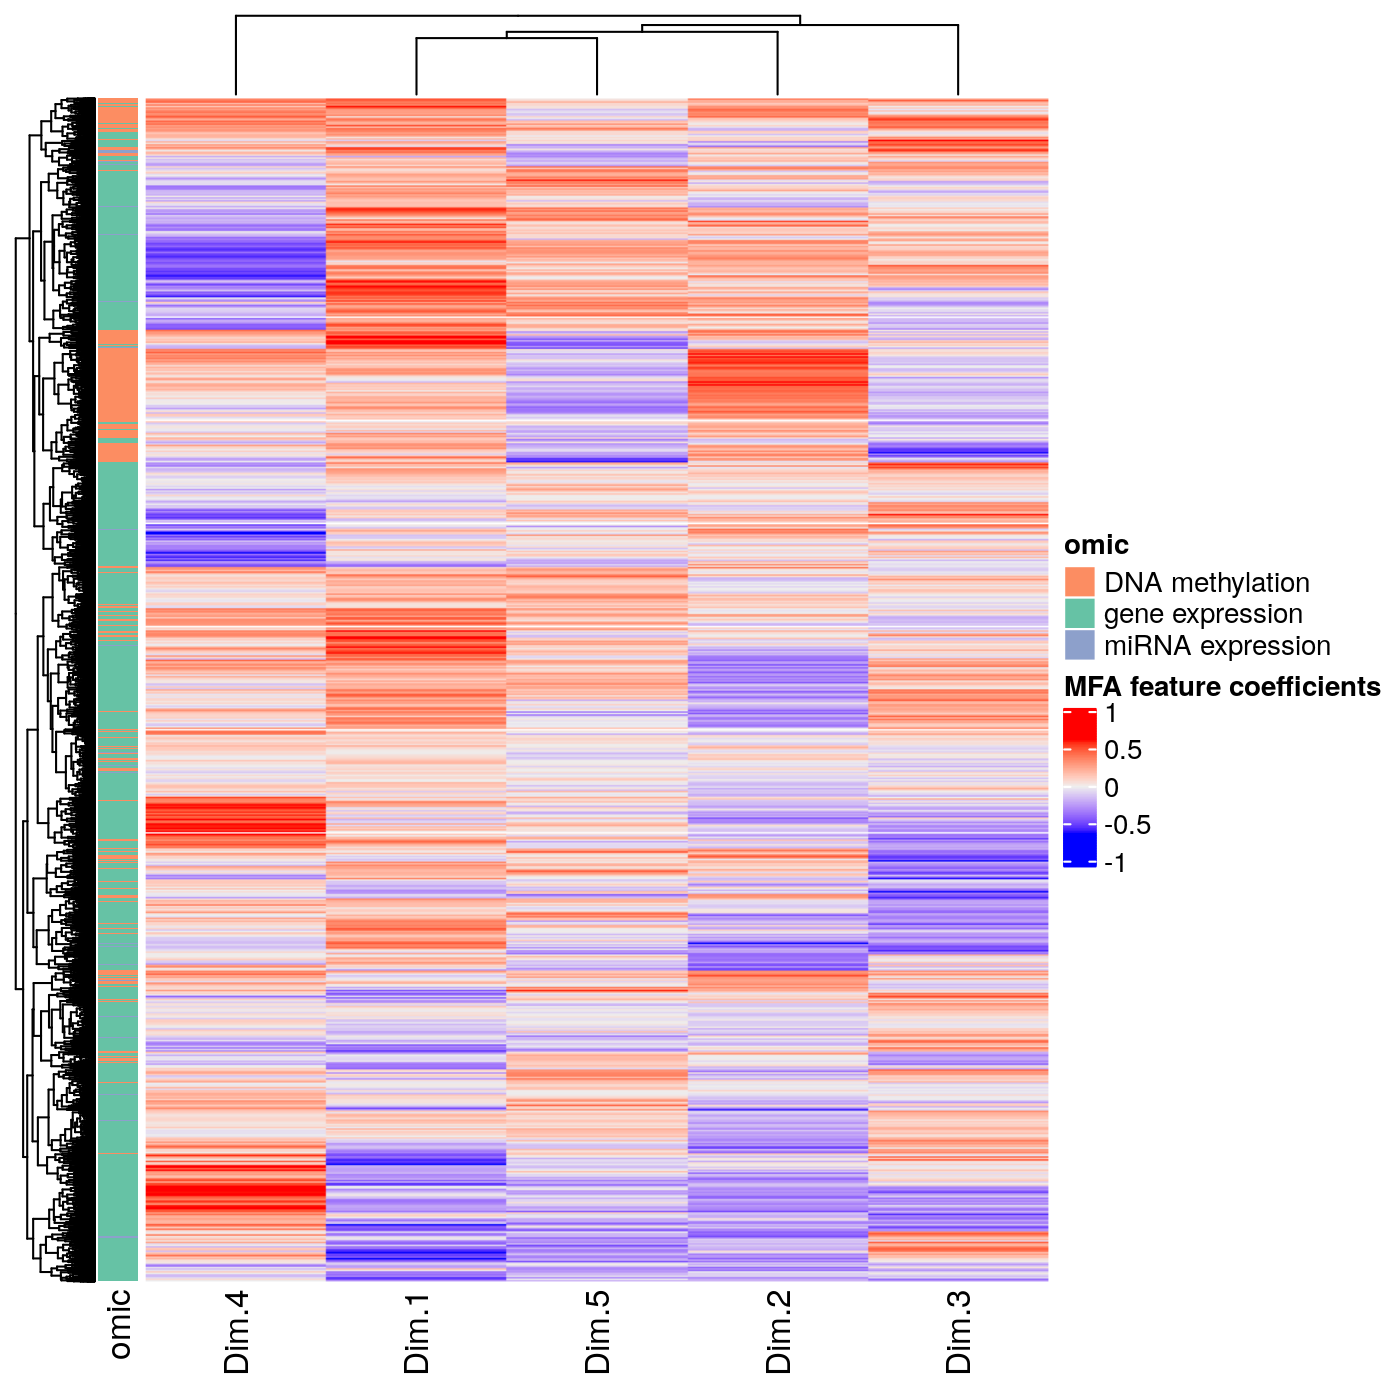

In [179]:
# create an annotation dataframe for the heatmap for each feature, indicating its omics-type
data_anno <- tibble(
  omics=c(rep('gene expression',dim(data_exp)[1]),
          rep('DNA methylation',dim(data_met)[1]),
          rep('miRNA expression',dim(data_mirna)[1])))

# generate the heat map
omics_col = setNames(RColorBrewer::brewer.pal(name = "Set2", n = 3), unique(data_anno$omics))

Heatmap(mfa.w, show_row_names=FALSE,
        name="MFA feature coefficients",
        left_annotation=rowAnnotation(omic=data_anno$omics, col = list(omic=omics_col)))

Closer inspection of this heatmap can reveal which feature values are predominantly associated with different factores of our latent space. In a perfect situation we would like this matrix to have a "disentangled" property where each feature is predominantly associated with only a single factor. However depending on a model and the dataset used it is not always possible. More sofisticated models, frequently apply **additional feature selection** step which allows to select only the "top" fatures, which contribute most to the factor separation.

In order to investigate the oncogenic processes that drive the differences between tumors, we may draw upon biological prior knowledge by looking for overlaps between genes that drive certain tumors, and genes involved in familiar biological processes.

We can take adventage of publicly availble resources such as *Gene Ontology Consortium’s GO terms*, *the Reactome pathways database*, and the *Kyoto Encyclopaedia of Genes and Genomes* to find lists of so-called gene sets, or pathways, which are sets of genes which are known to operate together in some biological function, e.g. protein synthesis, DNA mismatch repair, cellular adhesion, and many other functions. Gene set enrichment analysis is a method which looks for overlaps between genes which we have found to be of interest, e.g. by them being implicated in a certain tumor type, and the a-priori gene sets discussed above.

In the context of making sense of latent factors, the question we will be asking is whether the genes which drive the value of a latent factor (the genes with the highest factor coefficients) also belong to any interesting annotated gene sets, and whether the overlap is greater than we would expect by chance. If there are "N" genes in total, "K" of which belong to a gene set, the probability that "k" out of the "n" genes associated with a latent factor are also associated with a gene set is given by the hypergeometric distribution:

<img src="img/hypergeometric_1.png">

The hypergeometric test uses the hypergeometric distribution to assess the statistical significance of the presence of genes belonging to a gene set in the latent factor. The null hypothesis is that there is no relationship between genes in a gene set, and genes in a latent factor. When testing for over-representation of gene set genes in a latent factor, the "P" value from the hypergeometric test is the probability of getting "k" or more genes from a gene set in a latent factor:

<img src="img/hypergeometric_2.png">

The hypergeometric enrichment test is also referred to as Fisher’s one-sided exact test. This way, we can determine if the genes associated with a factor significantly overlap (beyond chance) the genes involved in a biological process. Because we will typically be testing many gene sets, we will also need to apply multiple testing correction, such as Benjamini-Hochberg correction.

In the example below, we look for the genes associated with preferentially with the first latent factor and use the *enrichR* package to query the Gene Ontology terms which might be overlapping:

In [ ]:
# select genes associated preferentially with the fist latent factor
genes.factor.1 <- rownames(data_exp)[max.col(mfa.w[1:dim(data_exp)[1],]) == 1]

# call the enrichr function to find gene sets enriched in the fist latent factor 
# in the GO Biological Processes 2018 library
go.factor.1 <- enrichR::enrichr(genes.factor.1,
                                databases = c("GO_Biological_Process_2018")
                                )$GO_Biological_Process_2018

#### SUMO interpret

Since SUMO belongs to the class of multi-omic data integration models that use similarity matrices rather then the feature matrices, its ability to interpret the features contribution to sample sparation directly by examination of factorized matrices is limited. Thus, SUMO package uses a separate gradient boosting classifier implemented in LightGBM - a tree-based model to detect the **importance of each feature towards each cluster**.

If you want to learn more about the LightGBM check [this](https://www.avanwyk.com/an-overview-of-lightgbm/) article.

Here is how you can run SUMO in **interpret** mode to find features supporting the cluster separation. This stop is very computationally expensive, due to performing the hyperparameter optimization using a random search with 5-fold cross-validation (performed on 80% of features) to avoid overfitting. Notice the use of "-t" argument which allows for specifying the number of cores for parellel computing.

# Where to go from now?

Think about an aspect of multi-omic integration that is the most interesting for you and how you can use the gain knowledge.

Here is a couple of ideas worth exploring:

1. How does the imputation of the data changes the reesults? Remove some values from the dataset and inspect 
the different type of data inputation vs full data using SUMO.


2. The integration of non-continous data types. As mentioned above the iCluster supports both somatic mutation and copy number data. The SUMO documentation includes the vignette showing how somatic mutations can be converted into continuous dataset and integrated. How does the ingration of somatic mutations change the sample classification? (Hint: yoou can download the somatic mutation data from UCSC Xena.)
